# Imports

In [ ]:
%load_ext autoreload?
%autoreload 2

In [1]:
import numpy as np
import math
import tensorflow as tf
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
import h5py
from keras.optimizers import Adamax, Nadam
import sys
import pickle

from interval import interval, inf

sys.path.append('/Users/stevenschaefer/VerticalCAS/GenerateNetworks/')
from GenerateNetworks.utils.safe_train import *
from GenerateNetworks.utils.plotting_utils import *
from GenerateNetworks.utils.projection_utils import *

In [2]:
print(tf.__version__)

2.13.0



# Constants

In [3]:
######## OPTIONS #########
ver = 4  # Neural network version
hu =  16 # Number of hidden units in each hidden layer in network
totalEpochs = 60  # Total number of training epochs
BATCH_SIZE = 2**8
EPOCH_TO_PROJECT = 1
trainingDataFiles = (
    "../../TrainingData/VertCAS_TrainingData_v2_%02d.h5"  # File format for training data
)
nnetFiles = "../../networks/ProjectionVertCAS_pra%02d_v%d_45HU_%03d.nnet"  # File format for .nnet files
COC_INTERVAL = [
    interval[-1000, -900],
    interval[20, 22],
]
DES_INTERVAL = [
    interval[100, 110],
    interval[20, 21],
]

# COC high, SDES2500 low
desired_interval = [
    interval[7000, 15000],  # COC
    None,  # DNC
    None,  # DND
    None,  # DES1500
    None,  # CL1500
    None,  # SDES1500
    None,  # SCL1500
    interval[-2000, 6000],  # SDES2500
    None,  # SCL2500
]
# TODO make this dynamically set
INTERVAL_WIDTH = 2
advisories = {
    "COC": 0,
    "DNC": 1,
    "DND": 2,
    "DES1500": 3,
    "CL1500": 4,
    "SDES1500": 5,
    "SCL1500": 6,
    "SDES2500": 7,
    "SCL2500": 8,
}
##########################

In [4]:
pra = 1

# ADVISORY INDICES
COC=0
DNC=1
DND=2
DES1500 = 3
CL1500 = 4
SDES1500=5
SCL1500=6
SDES2500=7
SCL2500=8

advisories = {
    "COC": 0,
    "DNC": 1,
    "DND": 2,
    "DES1500": 3,
    "CL1500": 4,
    "SDES1500": 5,
    "SCL1500": 6,
    "SDES2500": 7,
    "SCL2500": 8,
}

In [5]:
print("Loading Data for VertCAS, pra %02d, Network Version %d" % (pra, ver))
f = h5py.File(trainingDataFiles % pra, "r")
X_train = np.array(f["X"])
Q = np.array(f["y"])

training_idxs = np.logical_and(X_train[:, 1] == 0, X_train[:, 2] == 0)
print(len(training_idxs))
np.count_nonzero(training_idxs)

Loading Data for VertCAS, pra 01, Network Version 4
4053465


2665

In [6]:
X_train_filtered = X_train[training_idxs]
X_train = np.delete(X_train_filtered, [1,2], 1)
print(len(X_train))
Q = Q[training_idxs]

Q_orig = Q
X_train_orig = X_train

2665


In [7]:
X_train

array([[-0.5   , -0.5   ],
       [-0.4375, -0.5   ],
       [-0.375 , -0.5   ],
       ...,
       [ 0.375 ,  0.5   ],
       [ 0.4375,  0.5   ],
       [ 0.5   ,  0.5   ]])

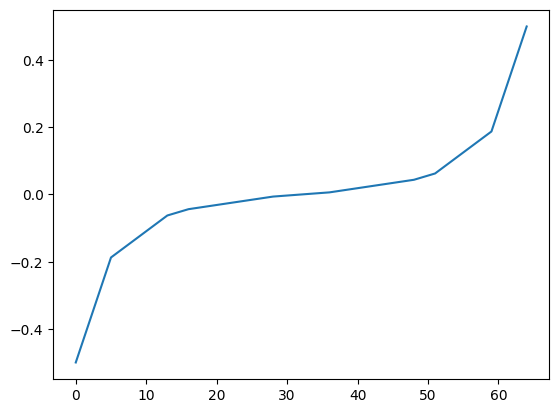

In [8]:
plt.plot(X_train[X_train[:, 1] == -0.5][:, 0])

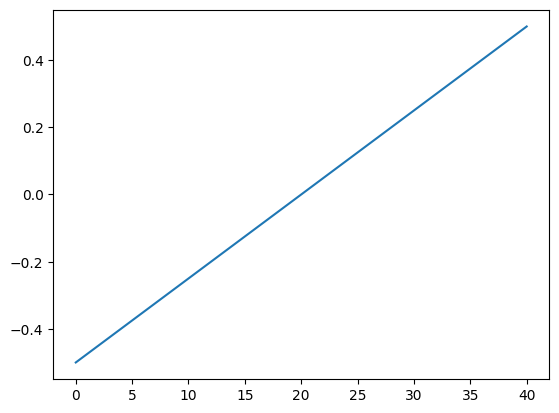

In [9]:
plt.plot(X_train[X_train[:, 0] == -0.5][:, 1])

In [10]:
hmax, _ = normalize_point(np.array([750, 40]))
hmax

0.046875

In [11]:
# smaller_domain_idxs = np.logical_and(X_train[:,0] > -1 * hmax, X_train[:, 0] < hmax)
# X_train = X_train[smaller_domain_idxs]
# Q = Q[smaller_domain_idxs]

In [12]:
N, numOut = Q.shape
print(f"Setting up model with {numOut} outputs and {N} training examples")
num_batches = N / BATCH_SIZE
print(f"Num batches {num_batches}")

Setting up model with 9 outputs and 2665 training examples
Num batches 10.41015625


In [13]:
X_train.shape

(2665, 2)

In [14]:
Q

array([[ 0.13870334, -0.19172892,  0.13383599, ..., -0.22739923,
        -0.23078384, -0.22756043],
       [ 0.13870334, -0.19172892,  0.13383599, ..., -0.22739923,
        -0.23078384, -0.22756043],
       [ 0.13870334, -0.19172892,  0.13383599, ..., -0.22739923,
        -0.23078384, -0.22756043],
       ...,
       [ 0.10910297,  0.10423501, -0.2213299 , ..., -0.26020412,
        -0.25714191, -0.26036533],
       [ 0.10910297,  0.10423501, -0.2213299 , ..., -0.26020412,
        -0.25714191, -0.26036533],
       [ 0.10910297,  0.10423501, -0.2213299 , ..., -0.26020412,
        -0.25714191, -0.26036533]])

In [15]:
Q.shape

(2665, 9)

In [16]:
# dict indexed by color/advisory of all points
xs = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}
ys = {0: [], 1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: [], 9: []}

for i, row in enumerate(X_train):
    real_coords = denormalize_point(row)
    y_row = Q[i]
    advisory_idx = np.argmax(y_row)
    color = colors[advisory_idx]
    scatter_x = real_coords[-1] # tau
    scatter_y = real_coords[0] # h 
    xs[advisory_idx].append(scatter_x)
    ys[advisory_idx].append(scatter_y)
print("done constructing dicts")


done constructing dicts


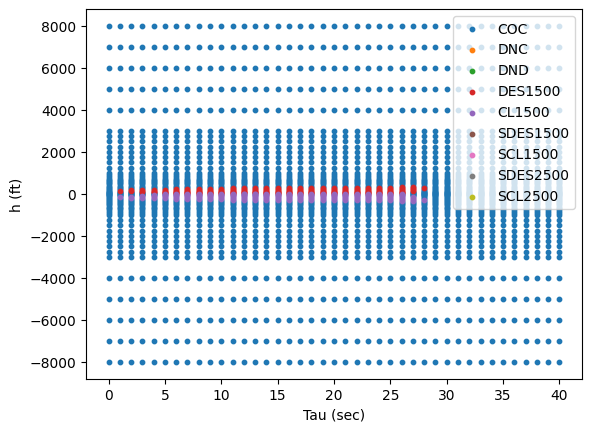

In [17]:
plt.figure()
plt.tight_layout()
for i in range(len(colors)):
    plt.scatter(xs[i], ys[i], s = 10)
plt.legend(action_names)
plt.xlabel("Tau (sec)")
plt.ylabel("h (ft)")
plt.show()

In [18]:
Q

array([[ 0.13870334, -0.19172892,  0.13383599, ..., -0.22739923,
        -0.23078384, -0.22756043],
       [ 0.13870334, -0.19172892,  0.13383599, ..., -0.22739923,
        -0.23078384, -0.22756043],
       [ 0.13870334, -0.19172892,  0.13383599, ..., -0.22739923,
        -0.23078384, -0.22756043],
       ...,
       [ 0.10910297,  0.10423501, -0.2213299 , ..., -0.26020412,
        -0.25714191, -0.26036533],
       [ 0.10910297,  0.10423501, -0.2213299 , ..., -0.26020412,
        -0.25714191, -0.26036533],
       [ 0.10910297,  0.10423501, -0.2213299 , ..., -0.26020412,
        -0.25714191, -0.26036533]])

In [19]:
Q.shape

(2665, 9)

In [20]:
desired_interval = [
    None,  # COC
    None,  # DNC
    None,  # DND
    interval[1, 10],  # DES1500
    None,  # CL1500
    None,  # SDES1500
    None,  # SCL1500
    None,  # SDES2500
    None,  # SCL2500
]

In [21]:
# Asymmetric loss function
lossFactor = 40.0

# NOTE(nskh): from HorizontalCAS which was updated to use TF
def asymMSE(y_true, y_pred):
    d = y_true - y_pred
    maxes = tf.argmax(y_true, axis=1)
    maxes_onehot = tf.one_hot(maxes, numOut)
    others_onehot = maxes_onehot - 1
    d_opt = d * maxes_onehot
    d_sub = d * others_onehot
    a = lossFactor * (numOut - 1) * (tf.square(d_opt) + tf.abs(d_opt))
    b = tf.square(d_opt)
    c = lossFactor * (tf.square(d_sub) + tf.abs(d_sub))
    d = tf.square(d_sub)
    loss = tf.where(d_sub > 0, c, d) + tf.where(d_opt > 0, a, b)
    return tf.reduce_mean(loss)

# Define model architecture
model = Sequential()
model.add(Dense(8, activation="relu", input_dim=2))
# model.add(Dense(16, activation="relu"))
# model.add(Dense(32, activation="relu"))
# model.add(Dense(64, activation="relu"))
# model.add(Dense(64, activation="relu"))

# model.add(Dense(numOut, init="uniform"))
model.add(Dense(numOut))
opt = Nadam(learning_rate=0.0003)
model.compile(loss=asymMSE, optimizer=opt, metrics=["accuracy"])

2023-10-27 14:38:51.394371: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2023-10-27 14:38:51.394439: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-10-27 14:38:51.394453: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-10-27 14:38:51.394595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-10-27 14:38:51.395110: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [22]:
model.fit(X_train, Q, epochs=10, batch_size=2**8, shuffle=True)

Epoch 1/10


2023-10-27 14:38:52.034480: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 1s 27ms/step - loss: 12.5161 - accuracy: 0.0886
Epoch 2/10
11/11 [==============================] - 0s 16ms/step - loss: 12.0908 - accuracy: 0.1021
Epoch 3/10
11/11 [==============================] - 0s 16ms/step - loss: 11.6283 - accuracy: 0.1171
Epoch 4/10
11/11 [==============================] - 0s 16ms/step - loss: 11.1584 - accuracy: 0.1328
Epoch 5/10
11/11 [==============================] - 0s 16ms/step - loss: 10.6921 - accuracy: 0.1505
Epoch 6/10
11/11 [==============================] - 0s 16ms/step - loss: 10.2334 - accuracy: 0.1704
Epoch 7/10
11/11 [==============================] - 0s 16ms/step - loss: 9.7829 - accuracy: 0.1906
Epoch 8/10
11/11 [==============================] - 0s 16ms/step - loss: 9.3389 - accuracy: 0.2094
Epoch 9/10
11/11 [==============================] - 0s 16ms/step - loss: 8.9055 - accuracy: 0.2311
Epoch 10/10
11/11 [==============================] - 0s 15ms/step - loss: 8.4806 - accuracy: 0.2570


In [23]:
denormalize_point(normalize_point(np.array([0, 20])))

array([ 0., 20.])

 86/304 [=======>......................] - ETA: 0s

2023-10-27 14:38:58.685268: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


304/304 [==============================] - 1s 2ms/step


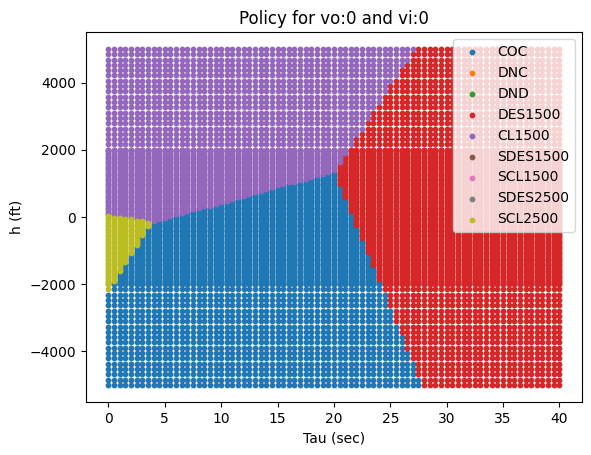

In [24]:
plot_policy(model)

on epoch 0
304/304 [==============================] - 0s 2ms/stepnd accuracy 


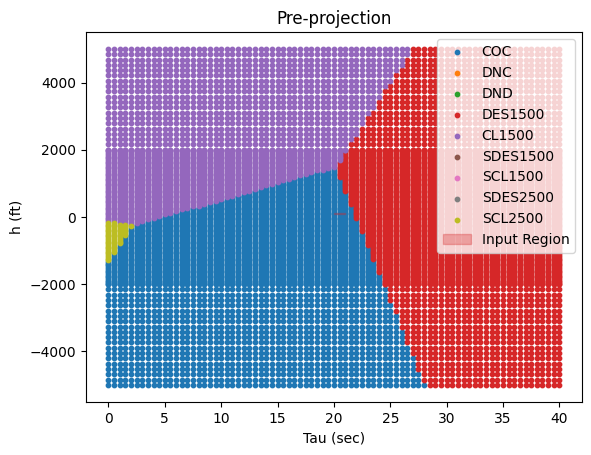

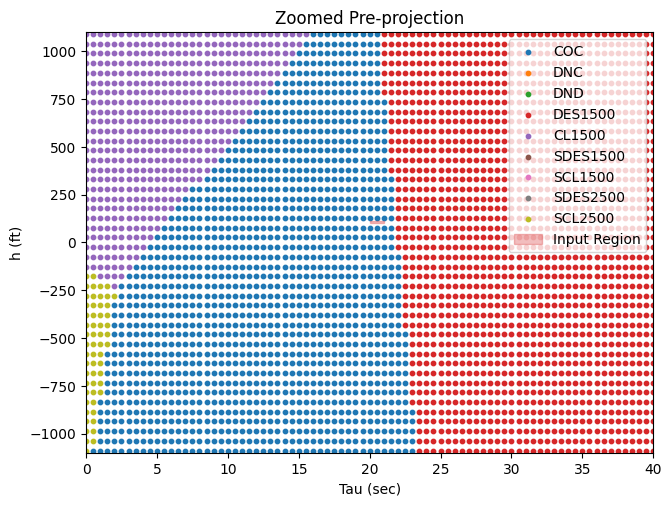

on epoch 1
304/304 [==============================] - 1s 2ms/stepnd accuracy 


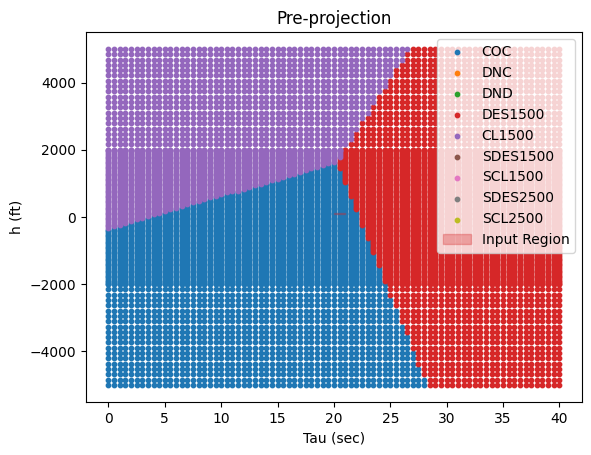

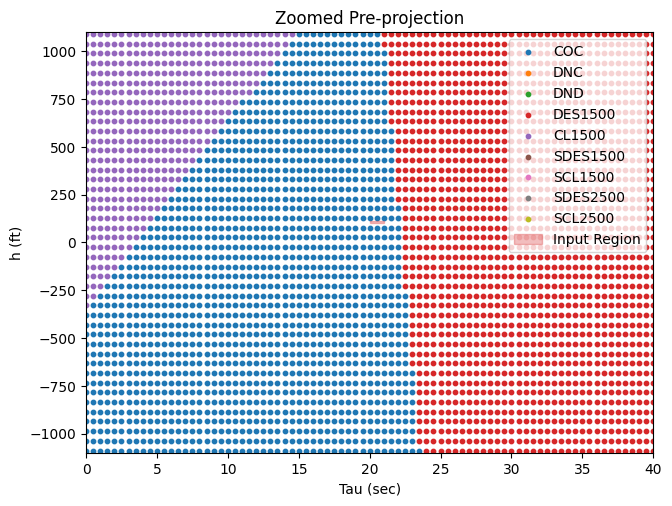

on epoch 2
304/304 [==============================] - 1s 2ms/stepnd accuracy


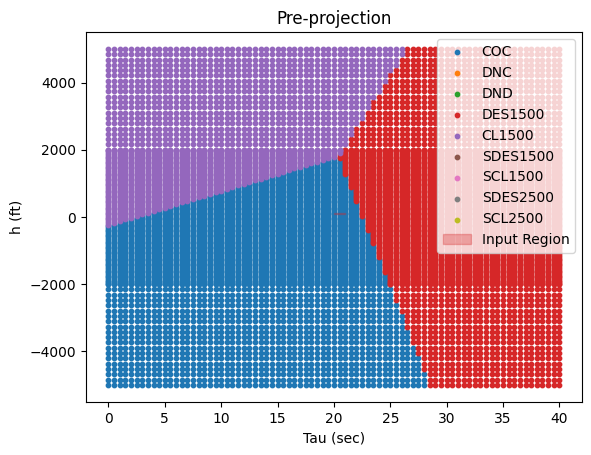

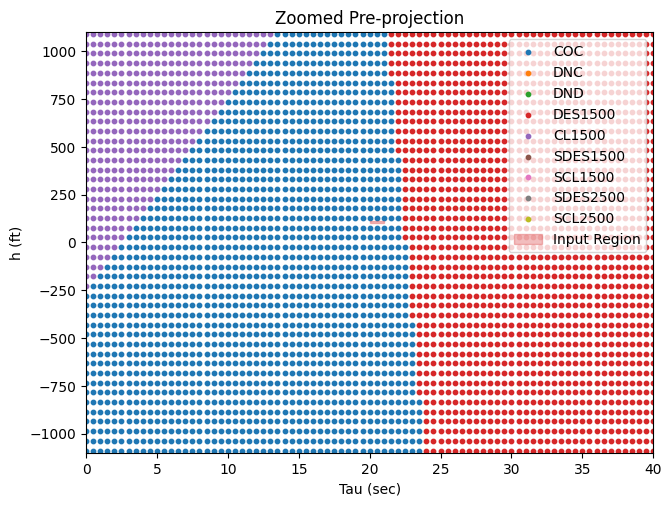

on epoch 3
304/304 [==============================] - 1s 2ms/stepnd accuracy 


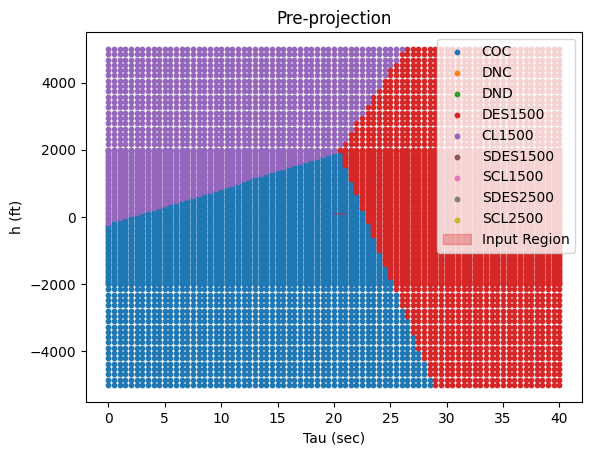

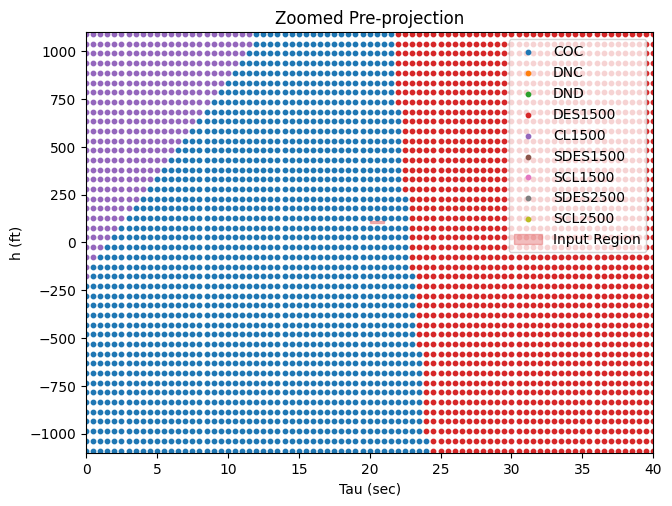

on epoch 4
304/304 [==============================] - 0s 2ms/stepnd accuracy


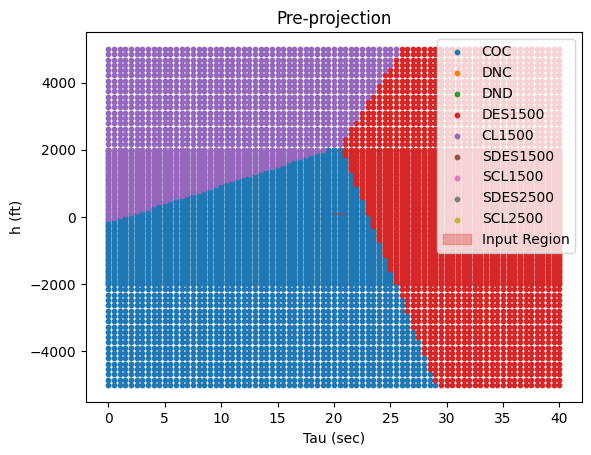

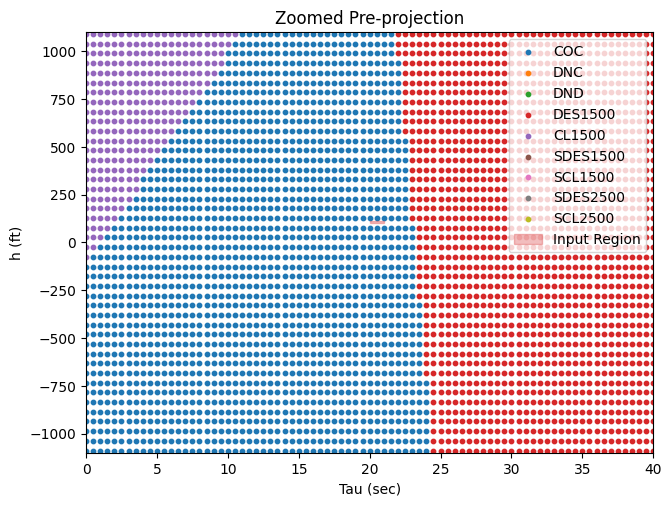

on epoch 5
304/304 [==============================] - 0s 2ms/stepd accuracy 


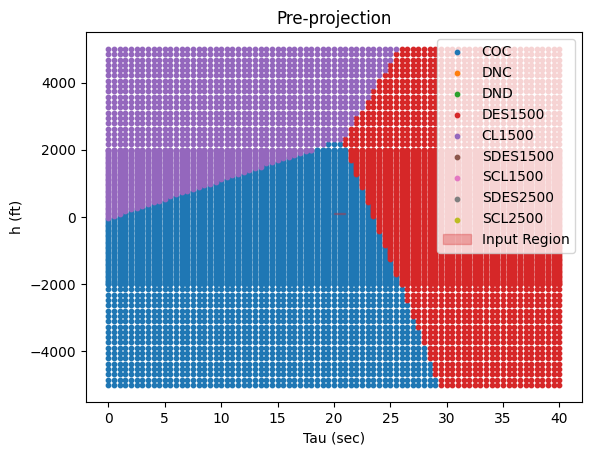

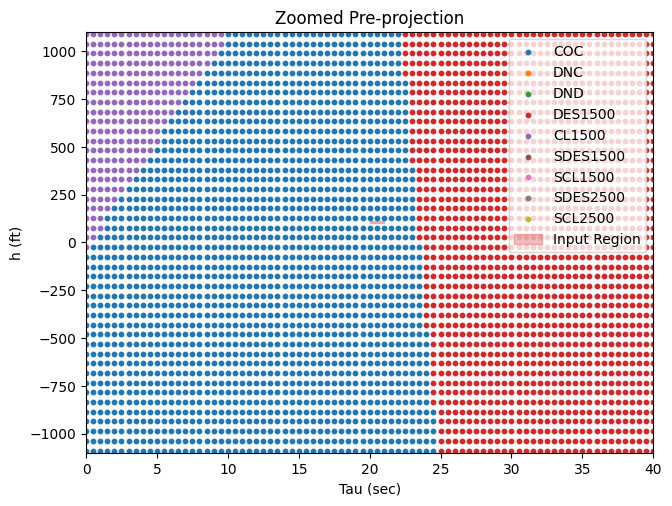

on epoch 6
304/304 [==============================] - 0s 2ms/stepnd accuracy


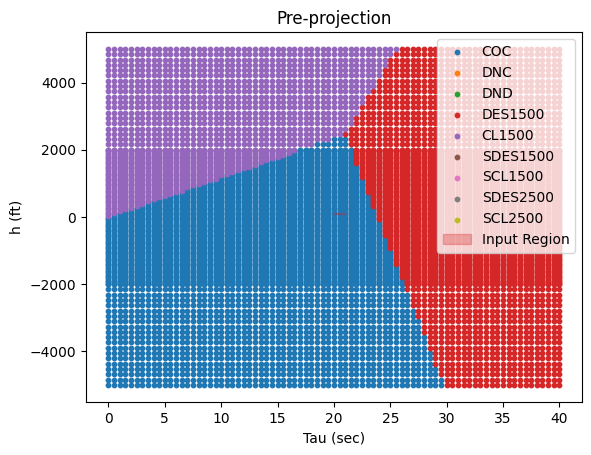

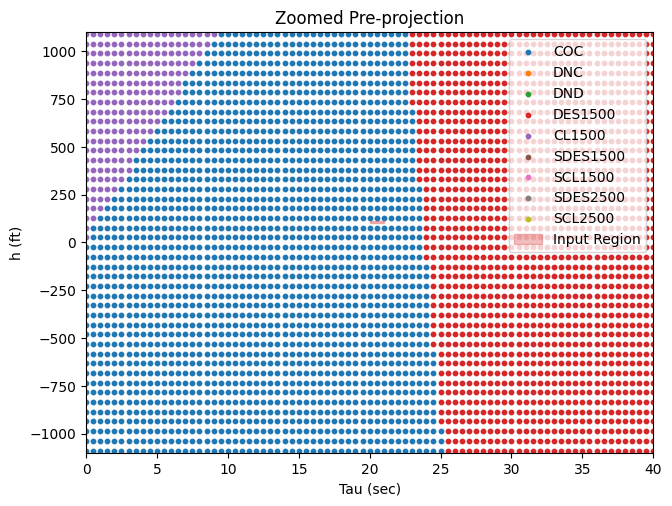

on epoch 7
304/304 [==============================] - 0s 2ms/stepd accuracy 


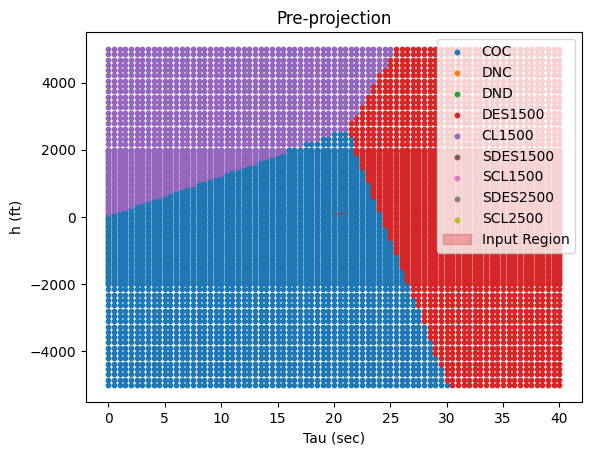

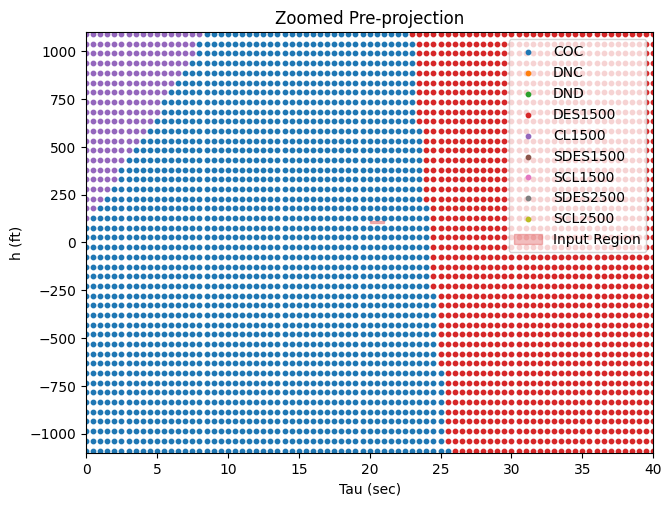

on epoch 8
304/304 [==============================] - 0s 2ms/stepd accuracy 


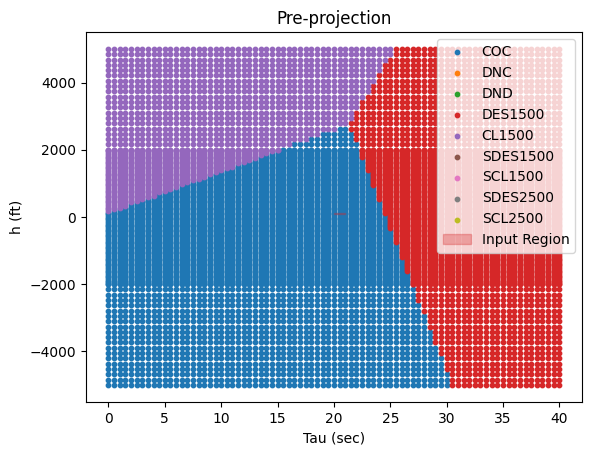

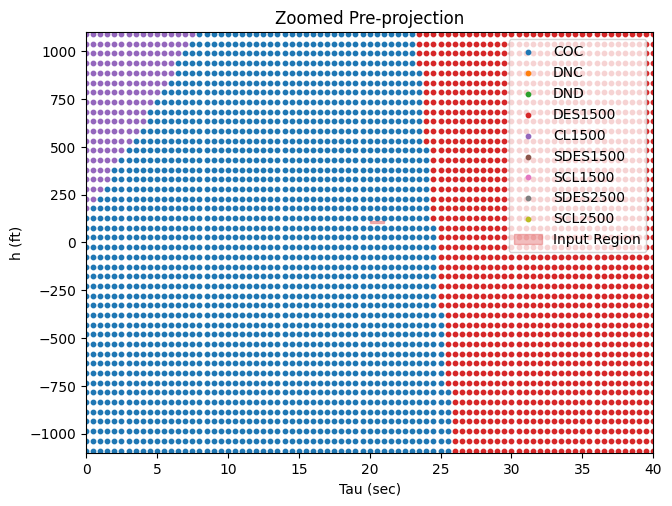

on epoch 9
304/304 [==============================] - 1s 2ms/stepand accuracy


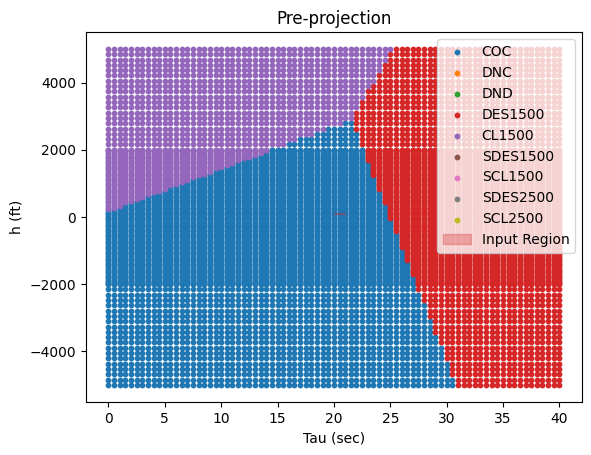

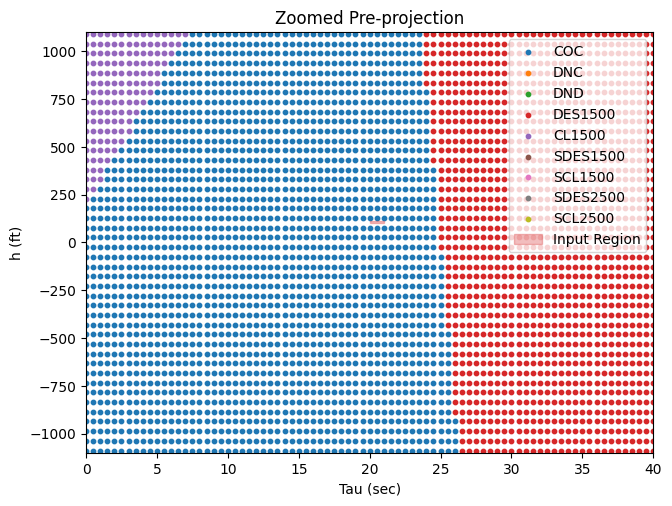

on epoch 10
304/304 [==============================] - 0s 2ms/stepand accuracy


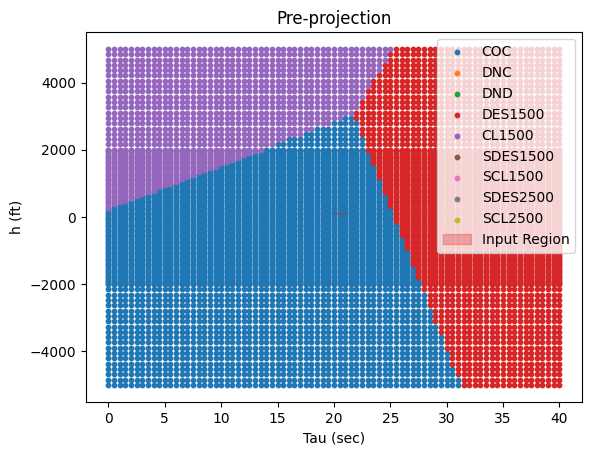

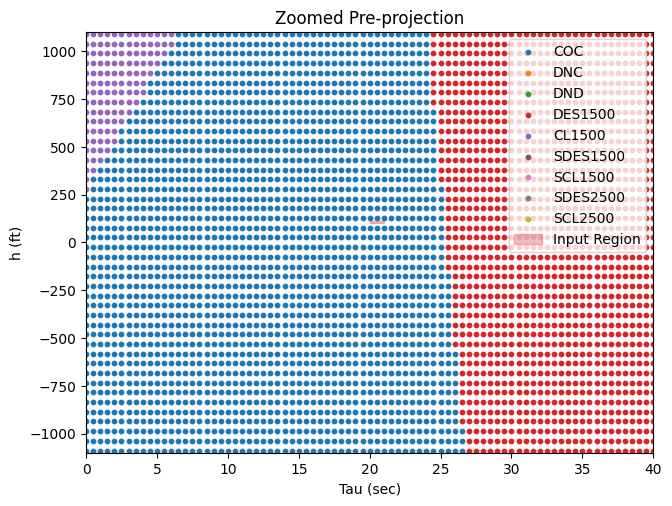

on epoch 11
304/304 [==============================] - 1s 2ms/stepand accura


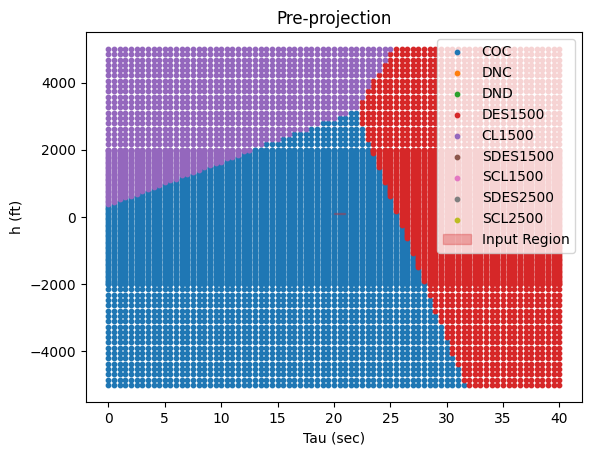

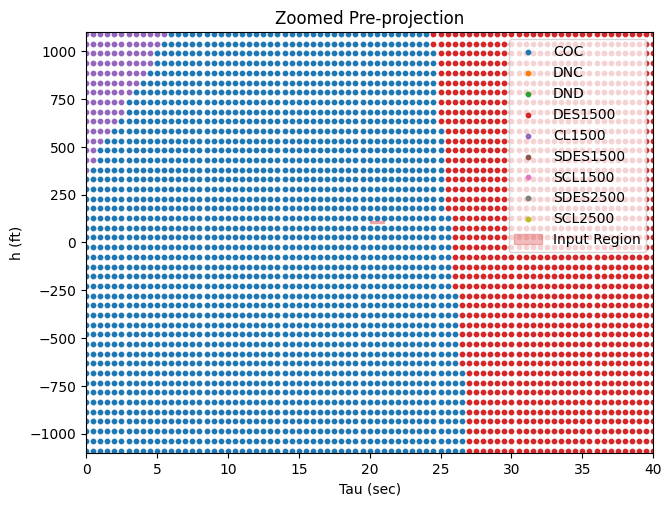

on epoch 12
304/304 [==============================] - 1s 2ms/stepnd accuracy 


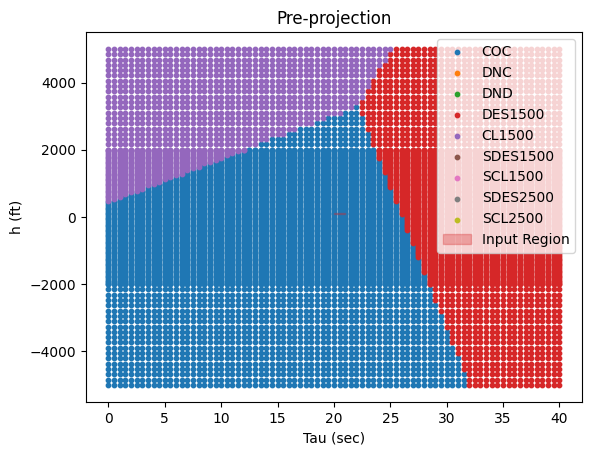

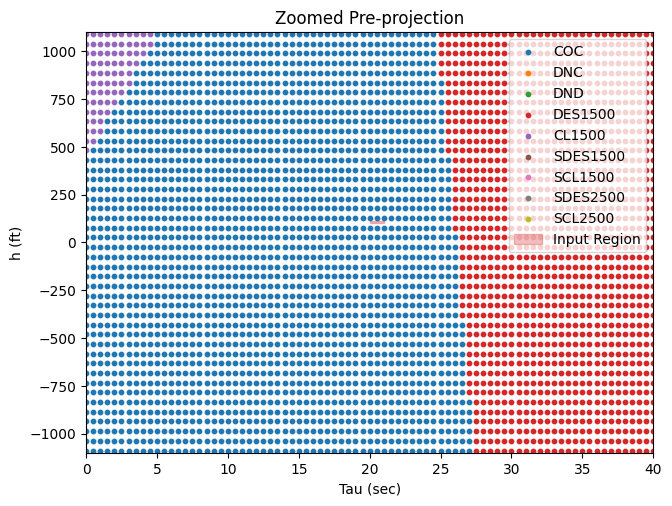

on epoch 13
304/304 [==============================] - 0s 2ms/stepnd accuracy


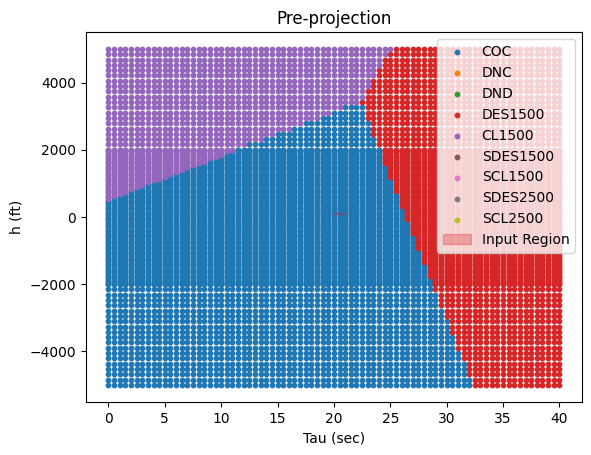

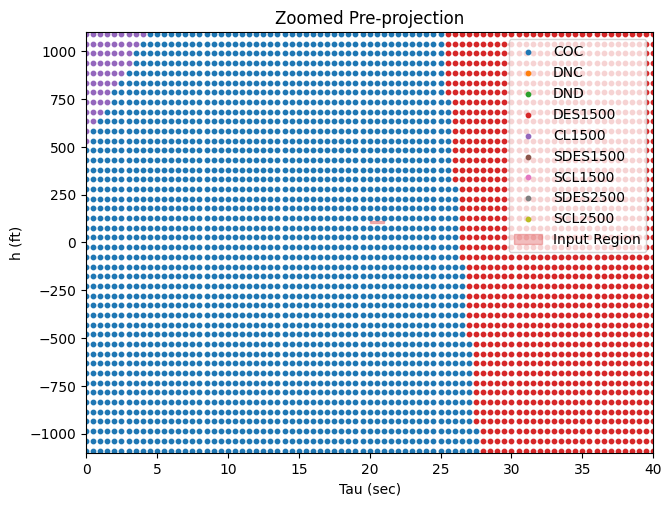

on epoch 14
304/304 [==============================] - 1s 2ms/stepnd accurac


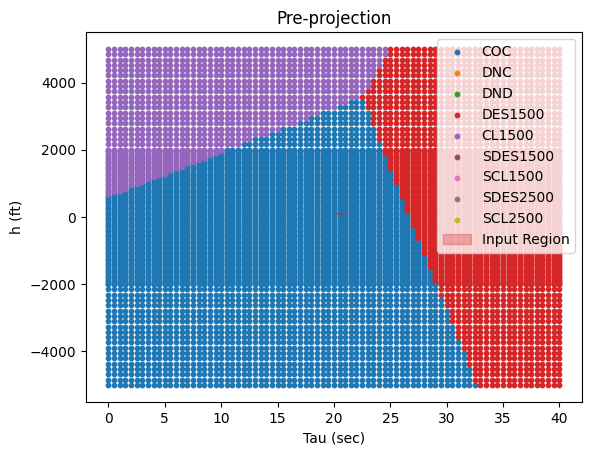

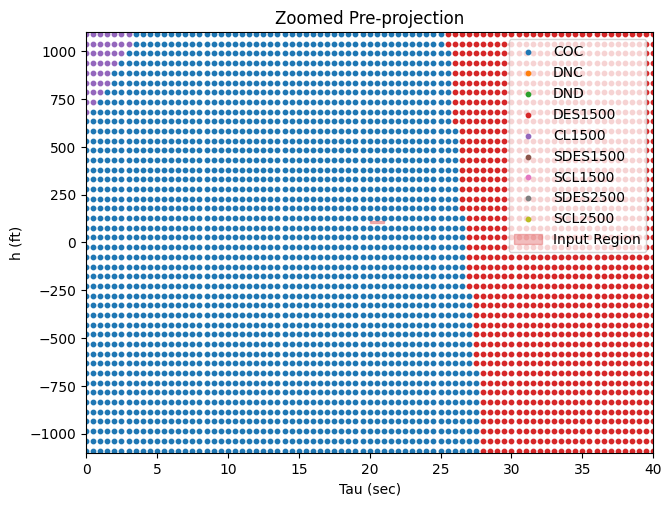

on epoch 15
304/304 [==============================] - 0s 2ms/stepand accuracy


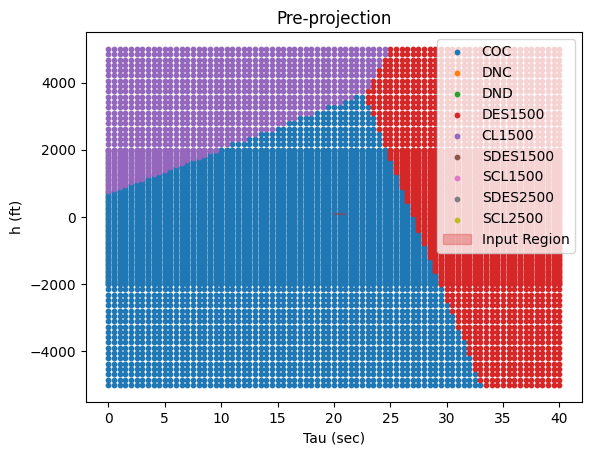

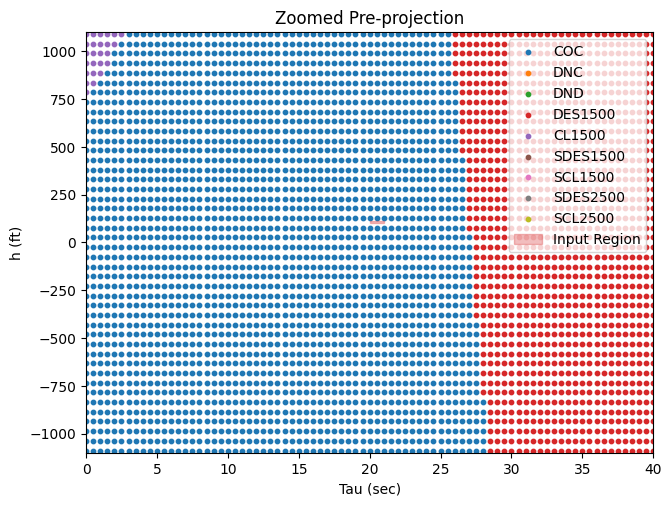

on epoch 16
304/304 [==============================] - 0s 2ms/stepnd accuracy 


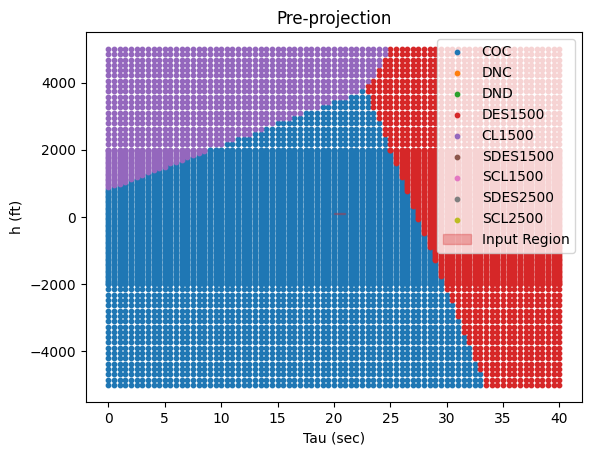

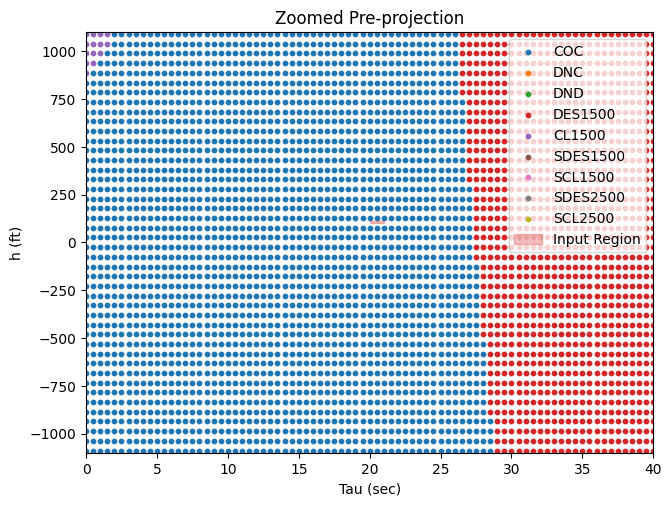

on epoch 17
304/304 [==============================] - 0s 2ms/stepand accurac


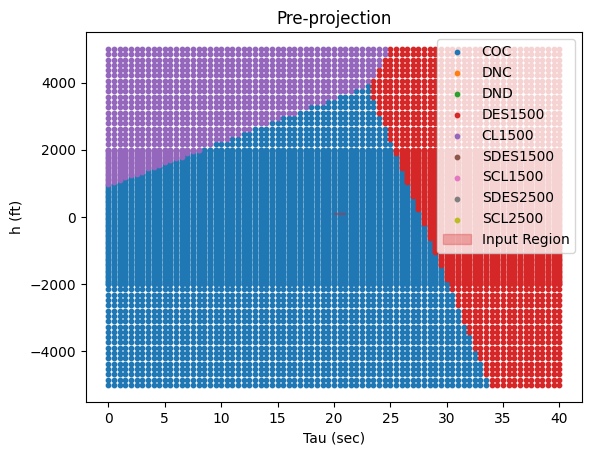

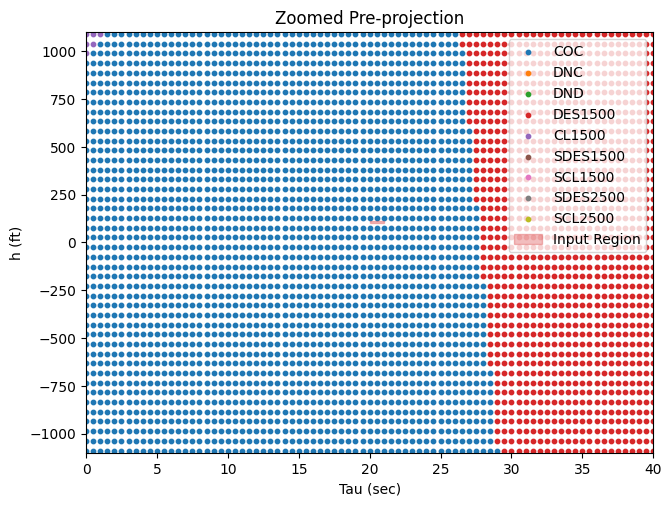

on epoch 18
304/304 [==============================] - 0s 2ms/stepand accuracy


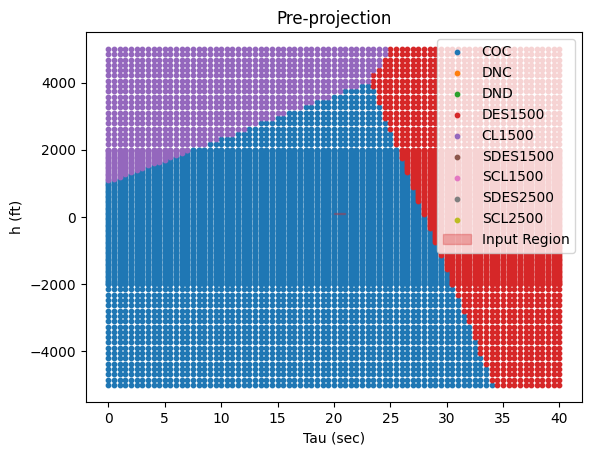

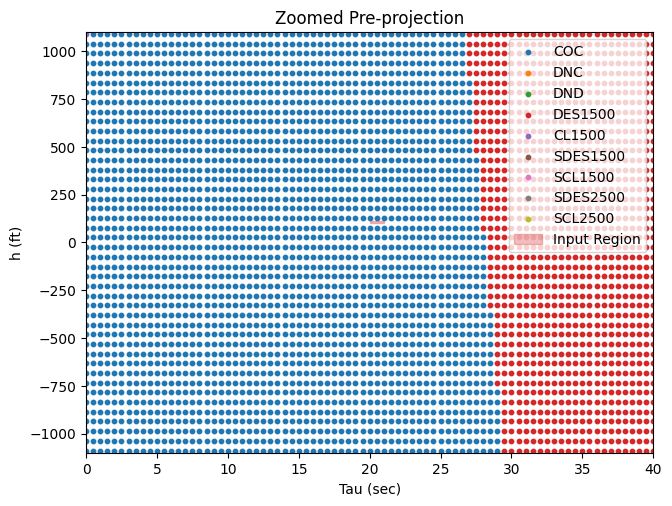

on epoch 19
304/304 [==============================] - 0s 2ms/stepnd accuracy 


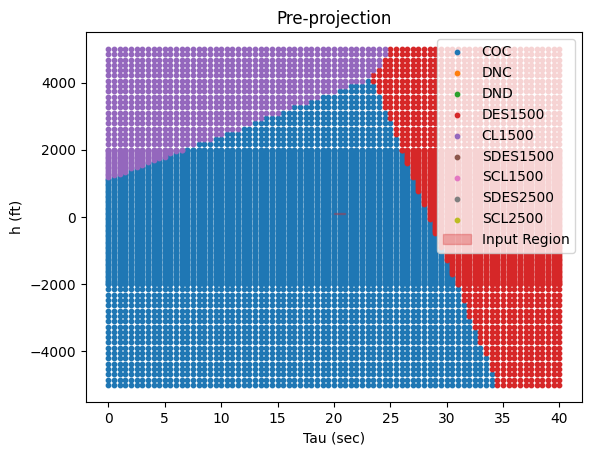

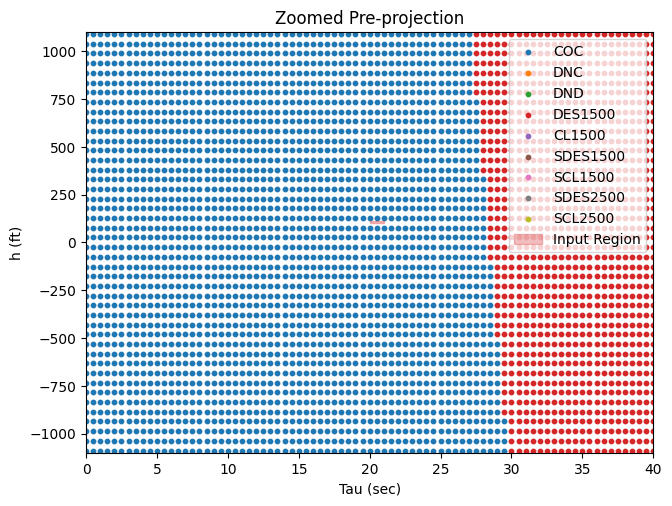

on epoch 20
304/304 [==============================] - 1s 2ms/stepand accuracy 


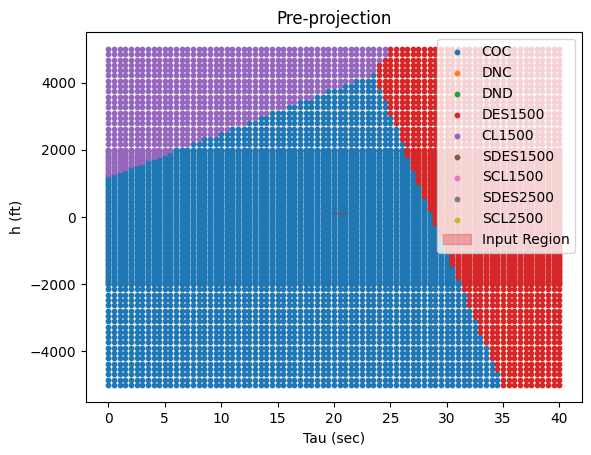

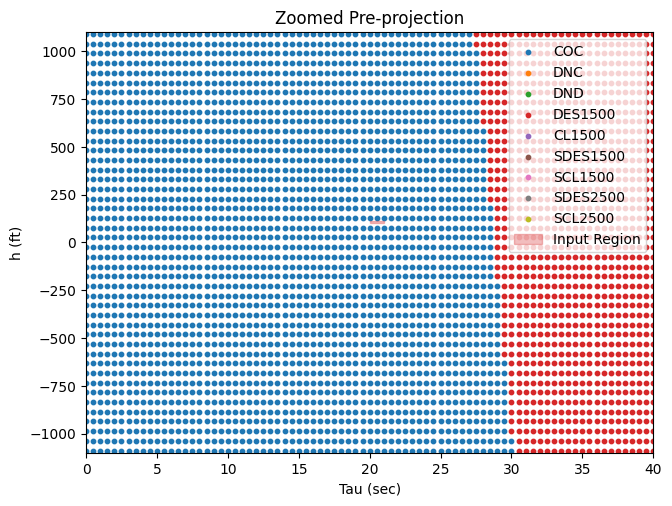

on epoch 21
304/304 [==============================] - 0s 2ms/stepand accurac


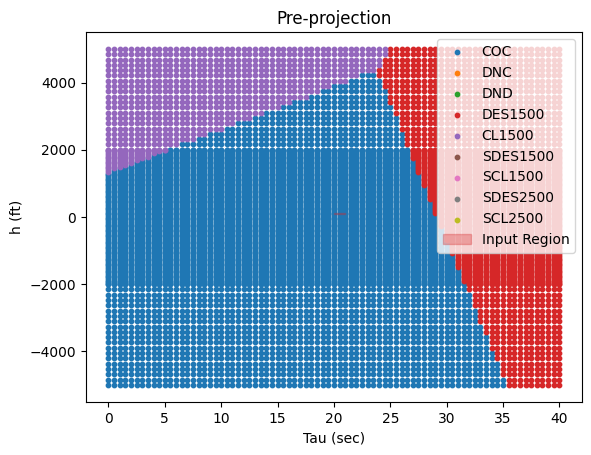

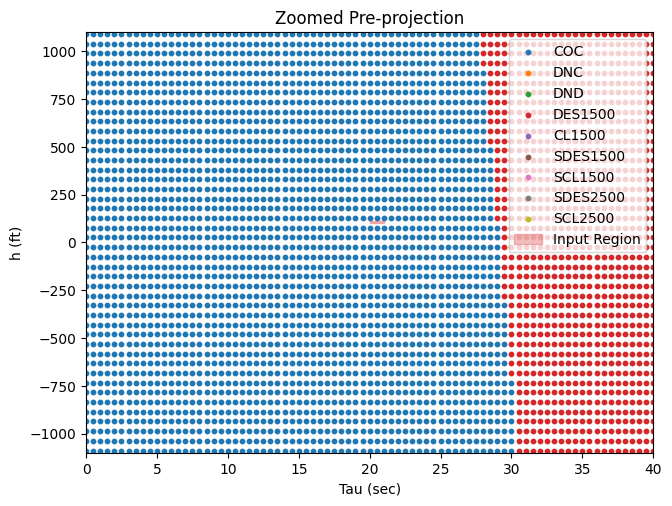

on epoch 22
304/304 [==============================] - 0s 2ms/stepand accurac


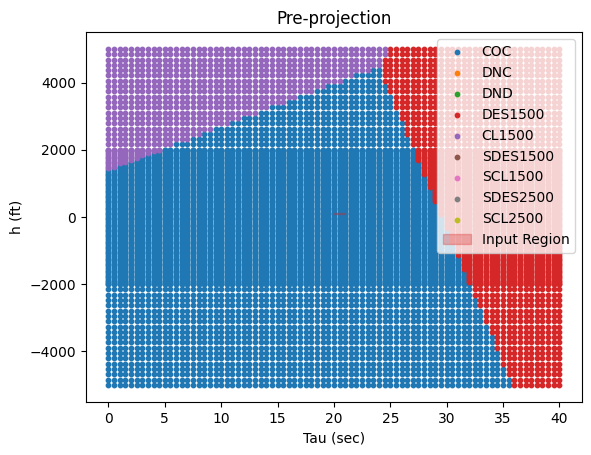

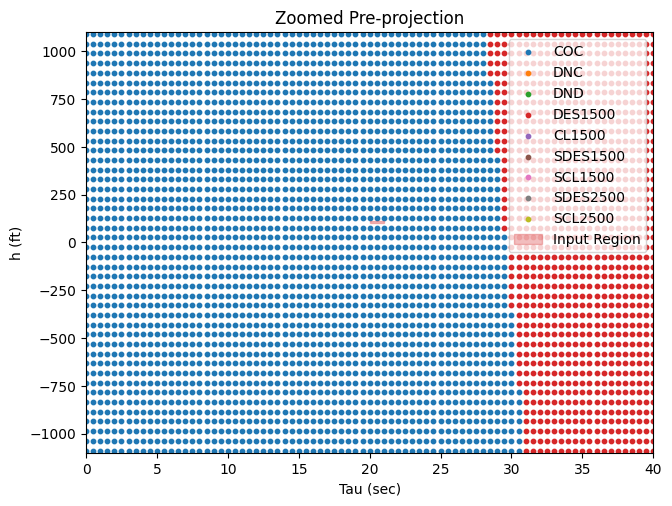

on epoch 23
304/304 [==============================] - 0s 2ms/stepand accurac


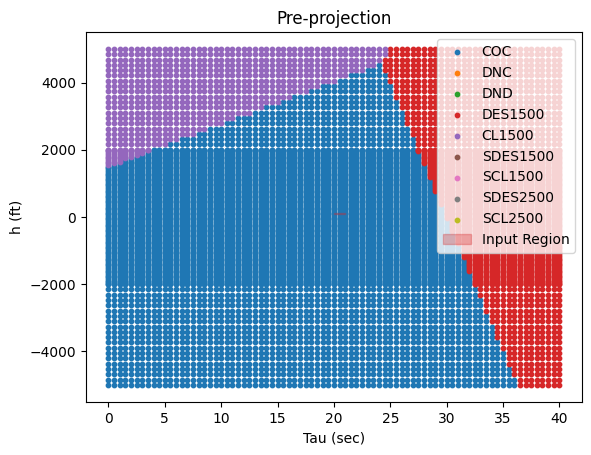

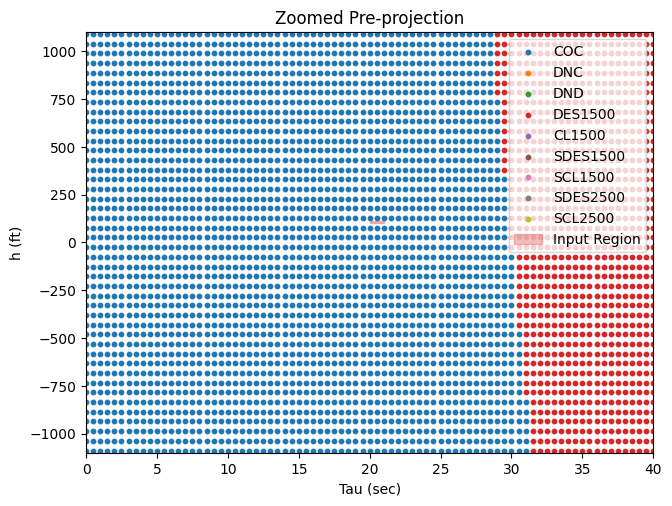

on epoch 24
304/304 [==============================] - 1s 2ms/stepnd accura


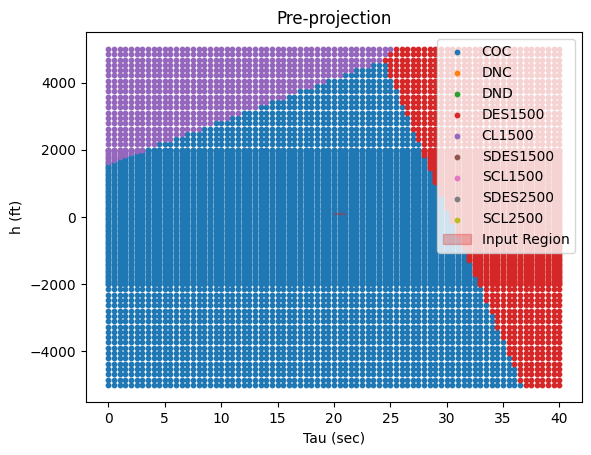

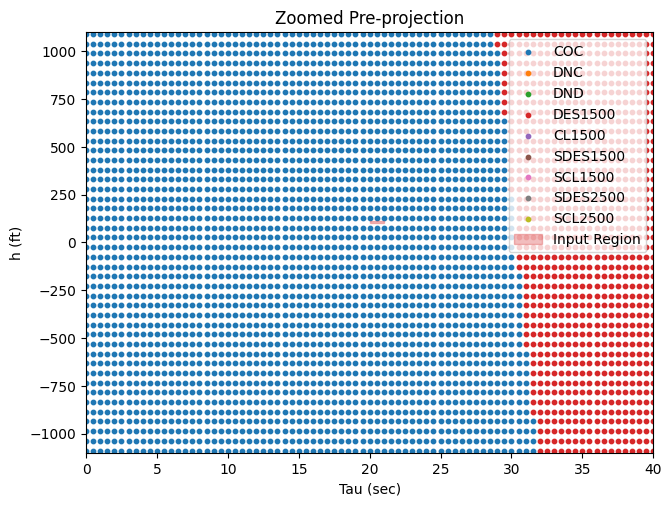

on epoch 25
304/304 [==============================] - 1s 2ms/stepand accurac


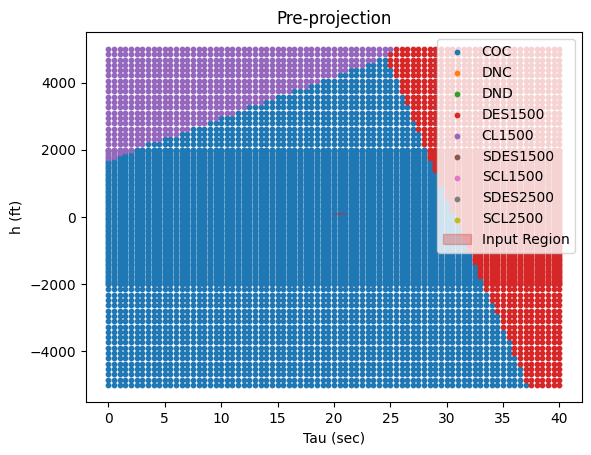

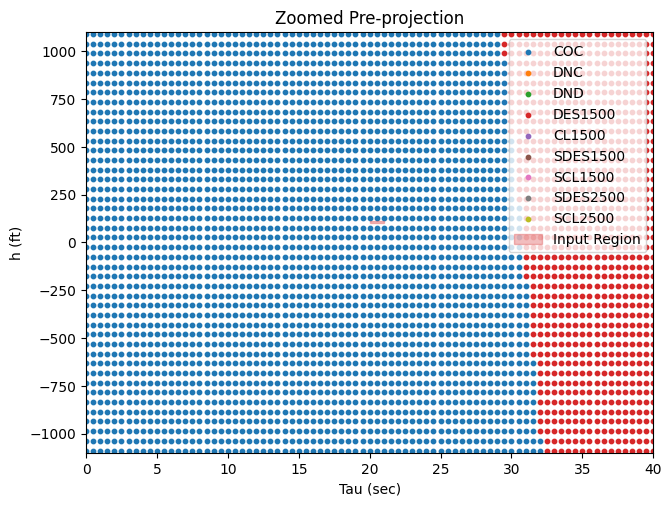

on epoch 26
304/304 [==============================] - 1s 2ms/stepand accurac


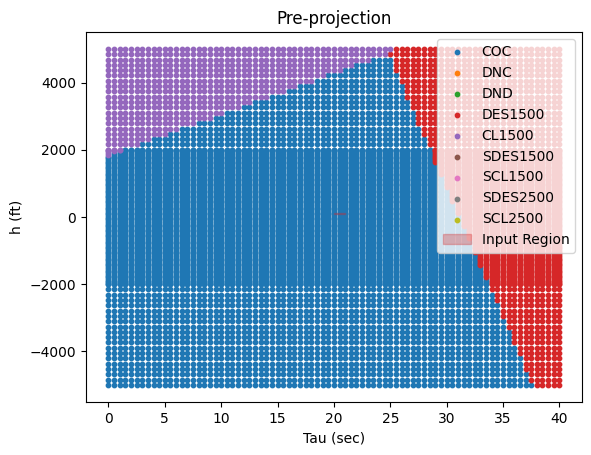

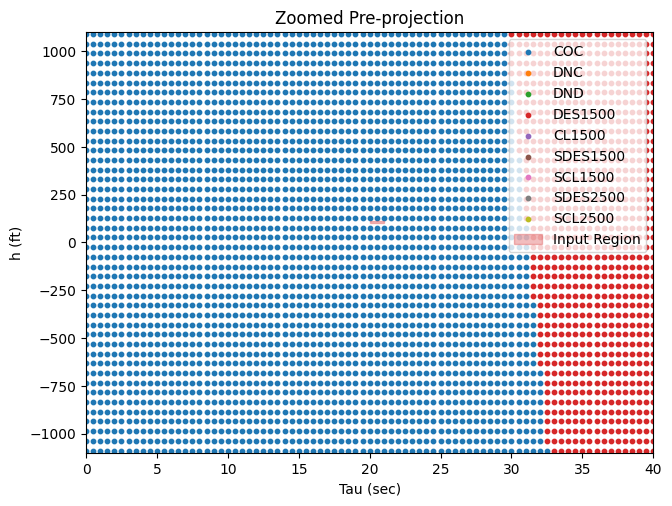

on epoch 27
304/304 [==============================] - 0s 2ms/stepand accurac


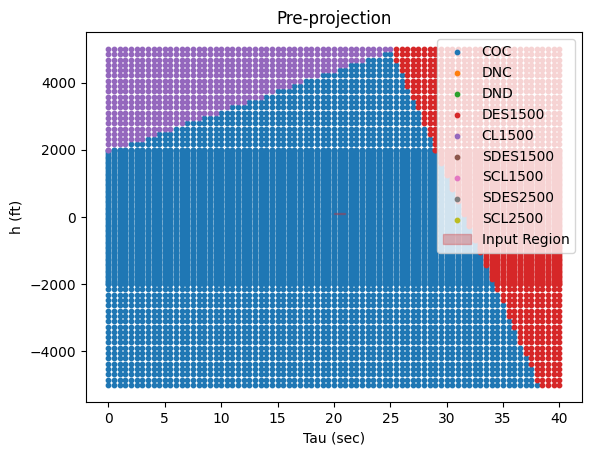

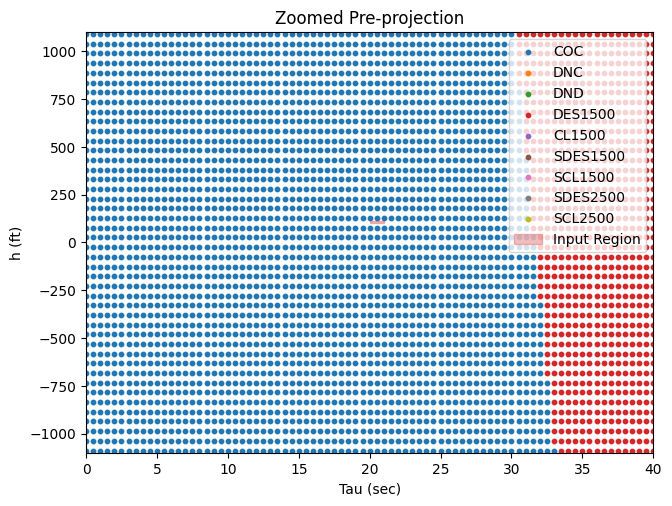

on epoch 28
304/304 [==============================] - 0s 2ms/stepand accurac


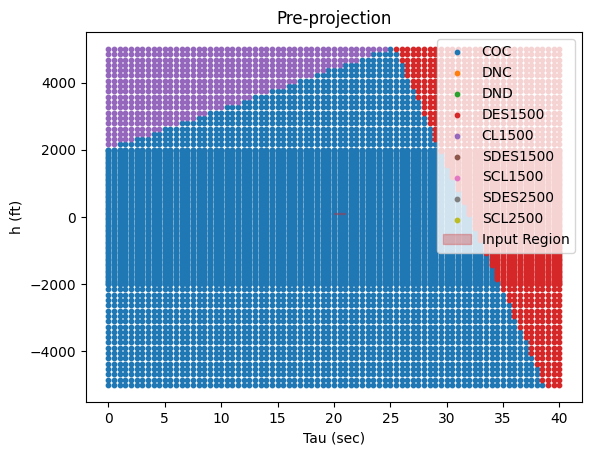

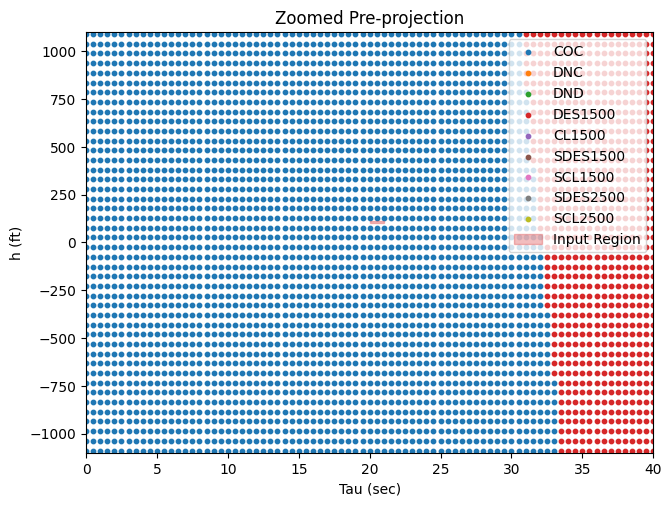

on epoch 29
304/304 [==============================] - 1s 2ms/stepand accurac


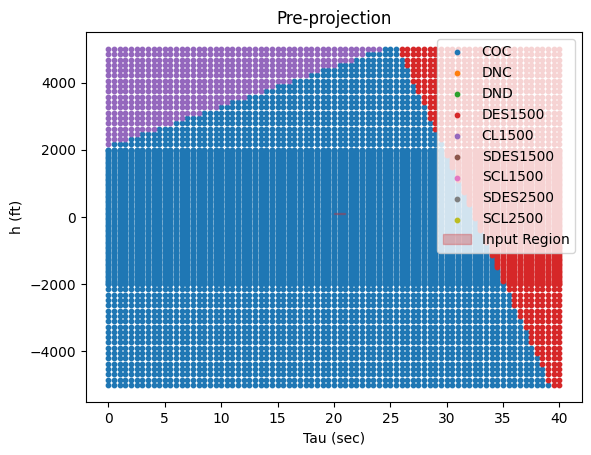

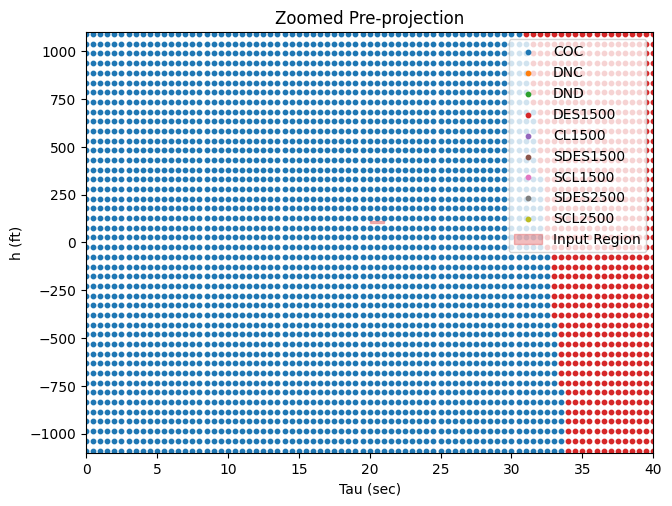

on epoch 30
304/304 [==============================] - 1s 2ms/stepnd accuracy


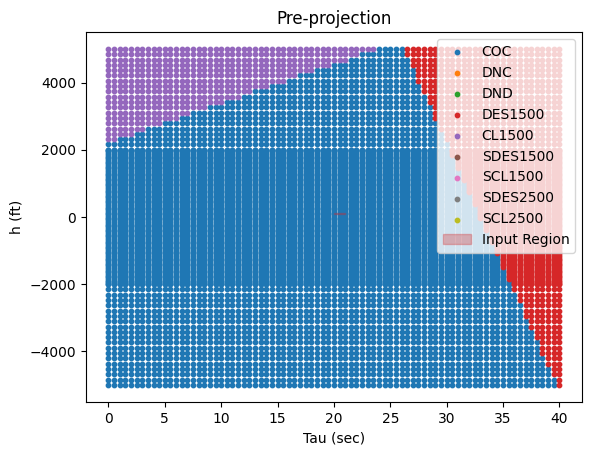

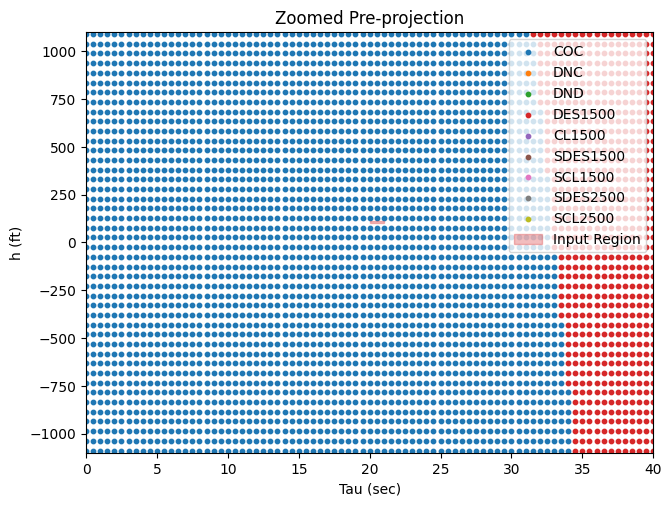

on epoch 31
304/304 [==============================] - 1s 2ms/stepd accuracy 


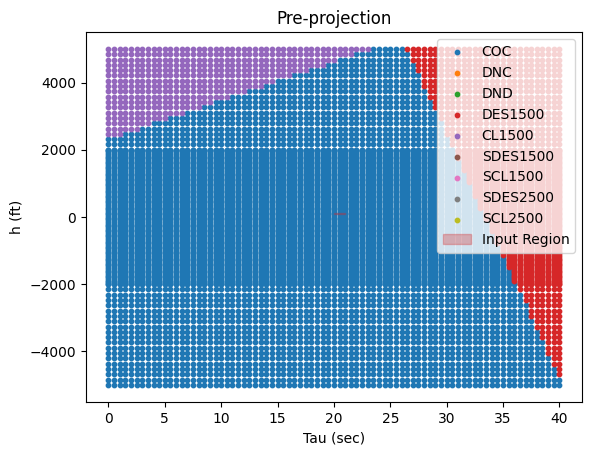

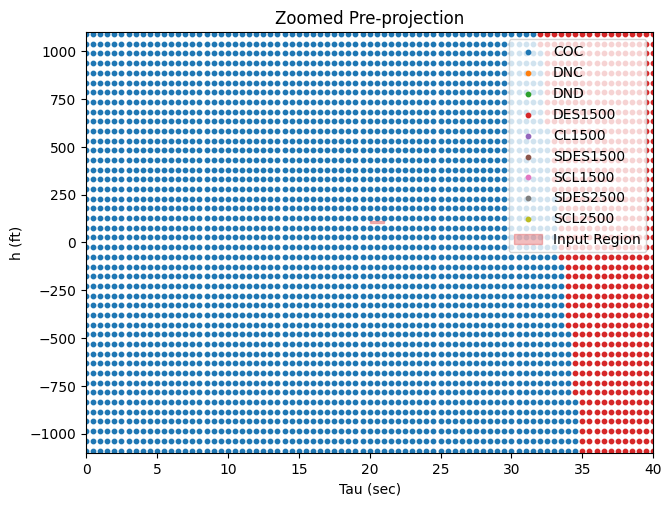

on epoch 32
304/304 [==============================] - 1s 2ms/stepand accur


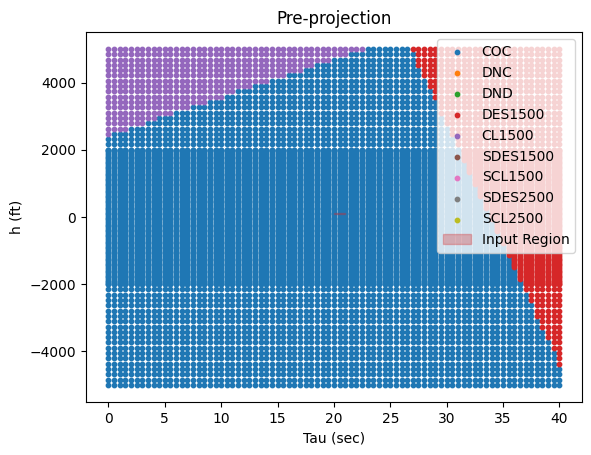

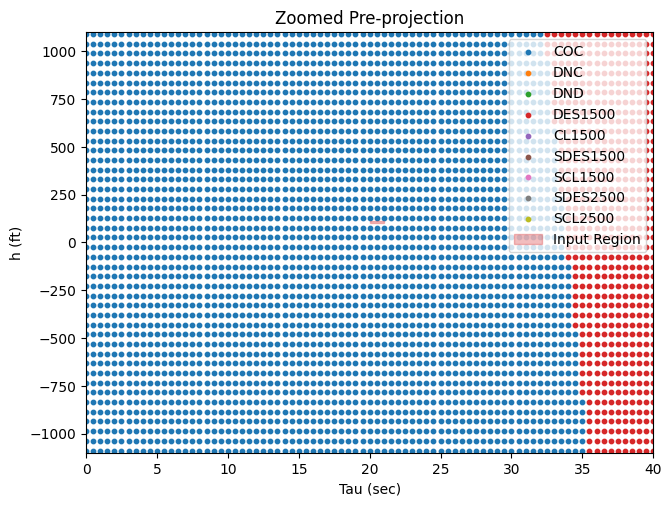

on epoch 33
304/304 [==============================] - 1s 2ms/stepand acc


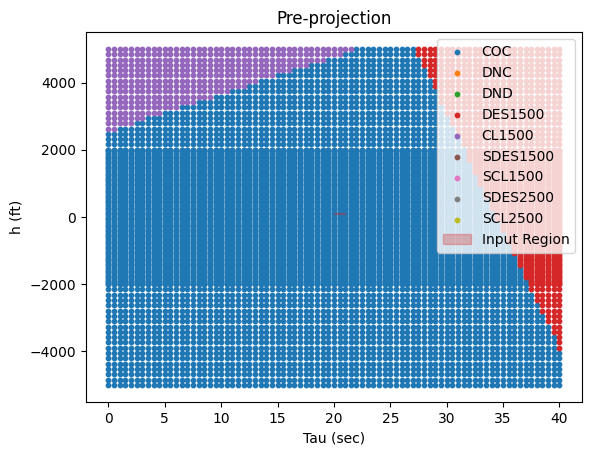

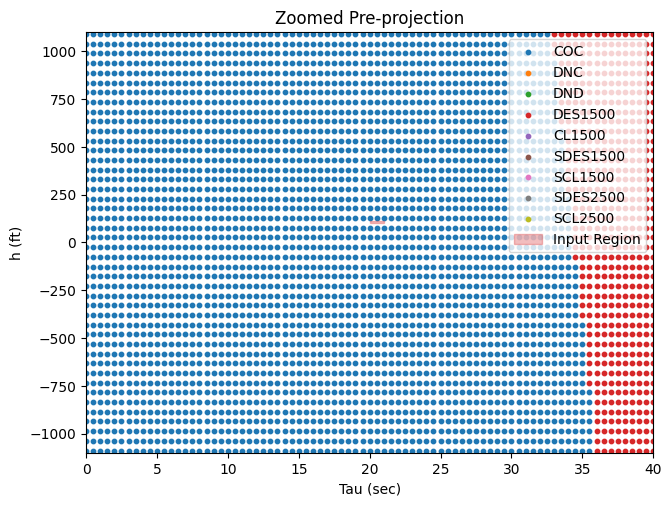

on epoch 34
304/304 [==============================] - 0s 1ms/stepand accuracy 


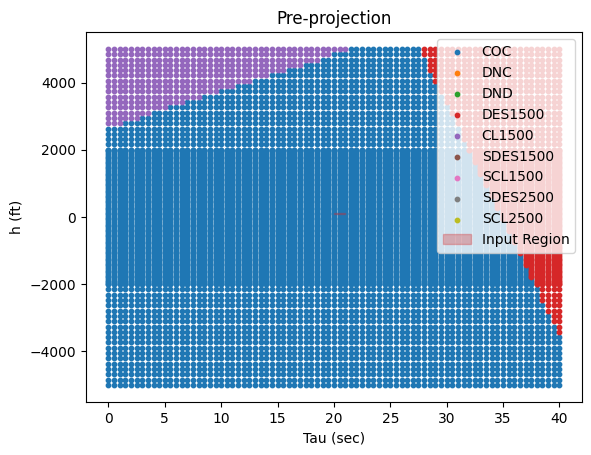

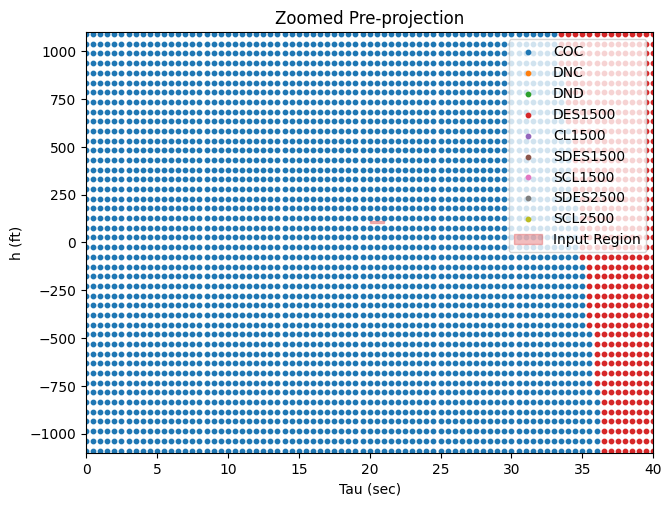

on epoch 35
304/304 [==============================] - 0s 2ms/stepand accurac


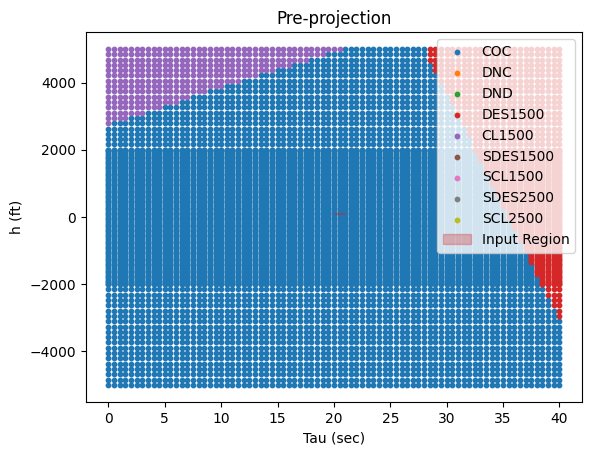

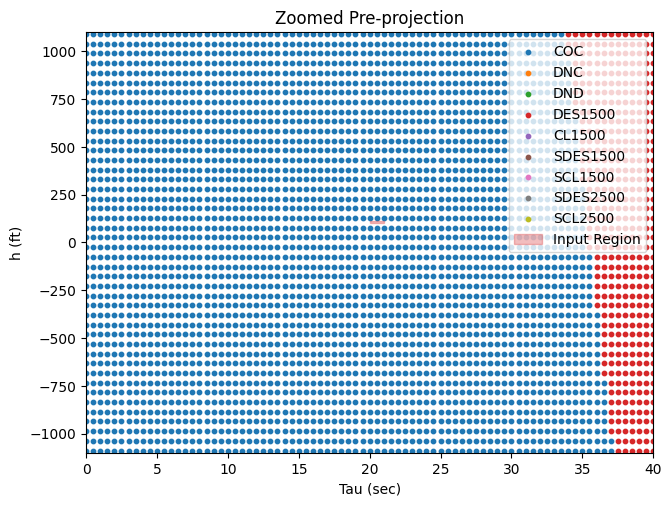

on epoch 36
304/304 [==============================] - 0s 2ms/stepand accurac


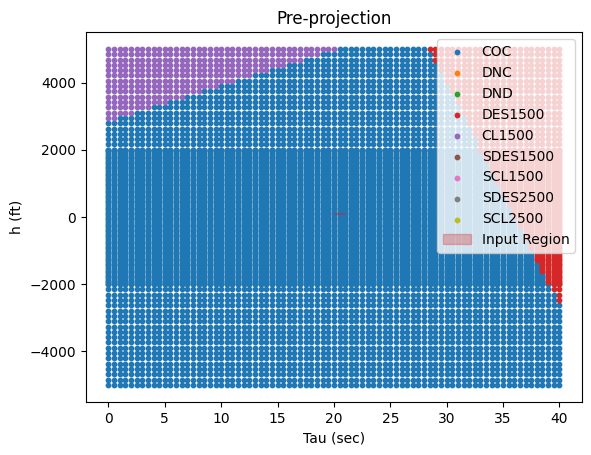

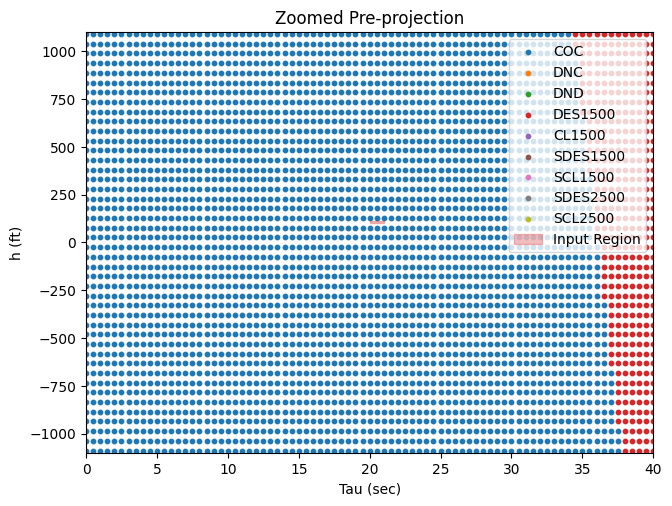

on epoch 37
304/304 [==============================] - 1s 2ms/stepand accur


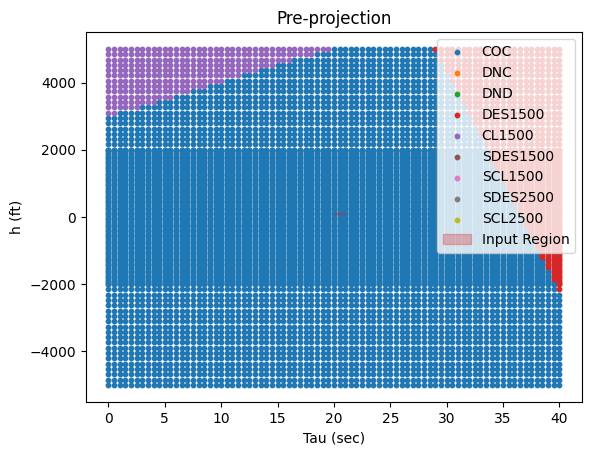

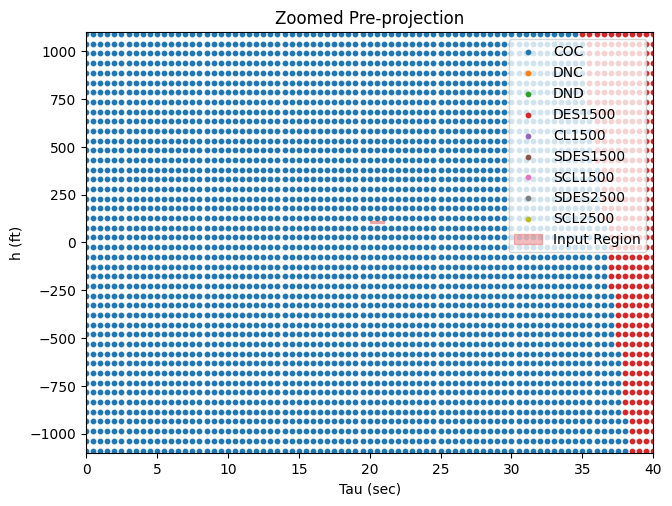

on epoch 38
304/304 [==============================] - 1s 2ms/stepand accurac


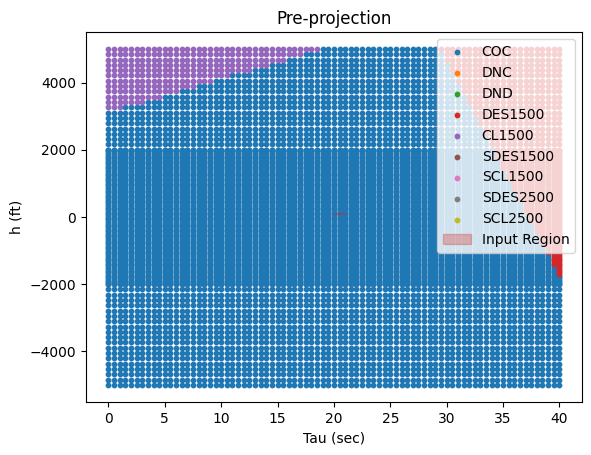

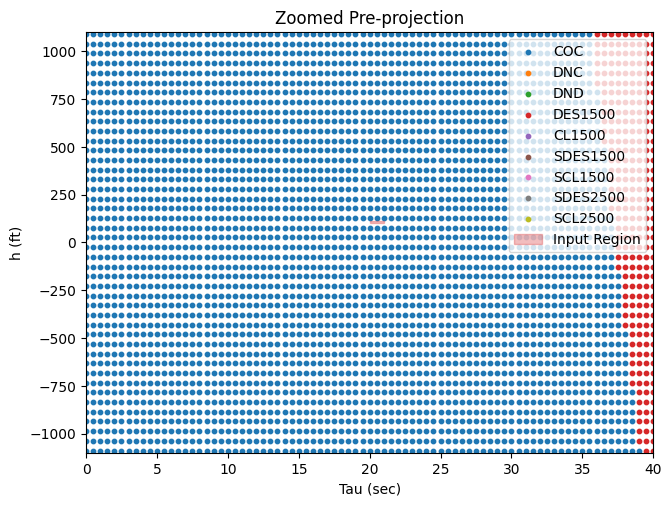

on epoch 39
304/304 [==============================] - 1s 2ms/stepand accur


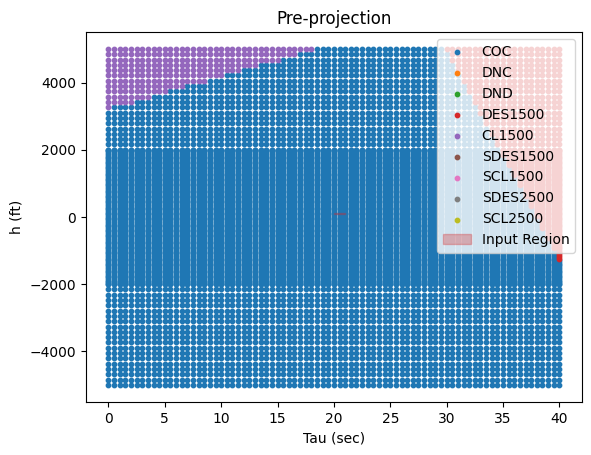

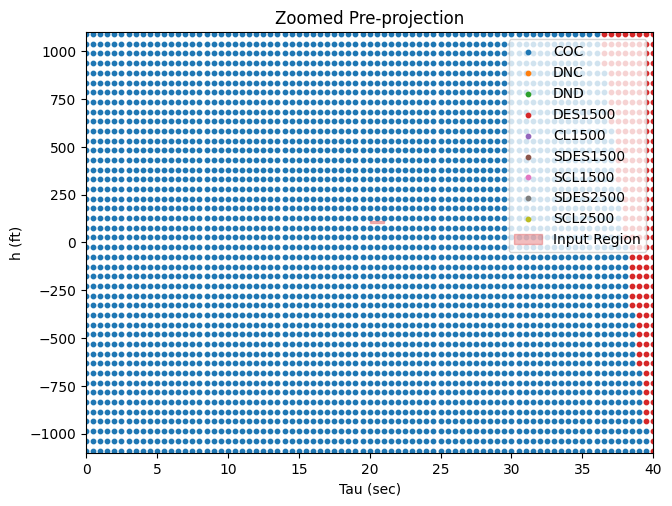

on epoch 40
304/304 [==============================] - 0s 2ms/stepand accurac


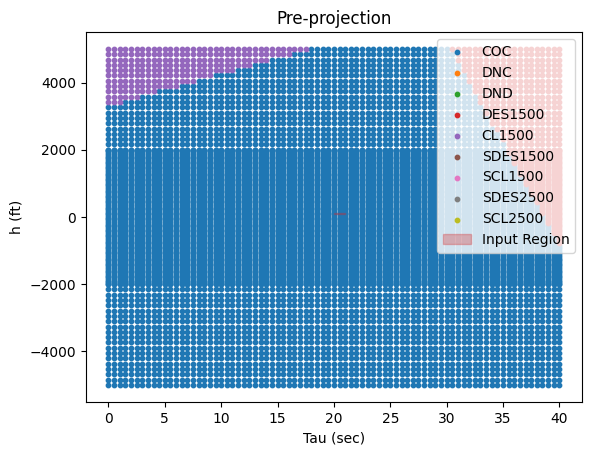

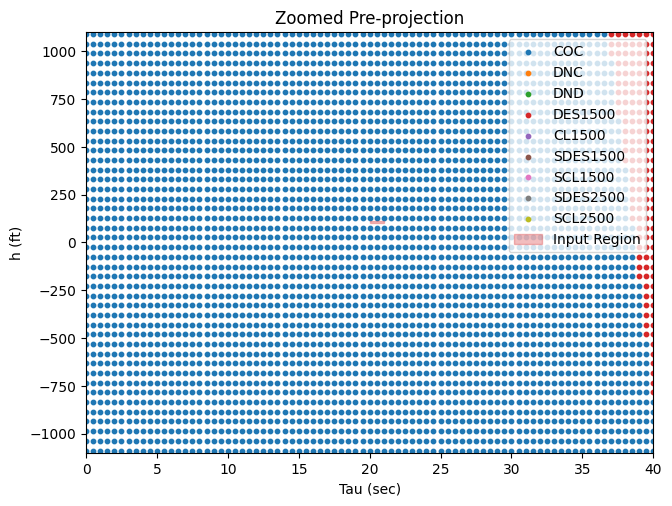

on epoch 41
304/304 [==============================] - 0s 2ms/stepand accurac


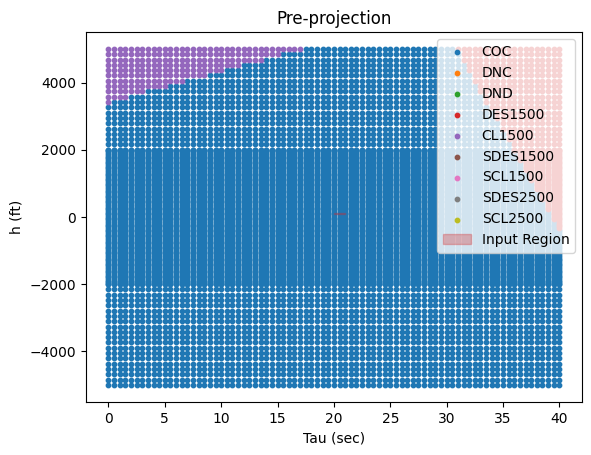

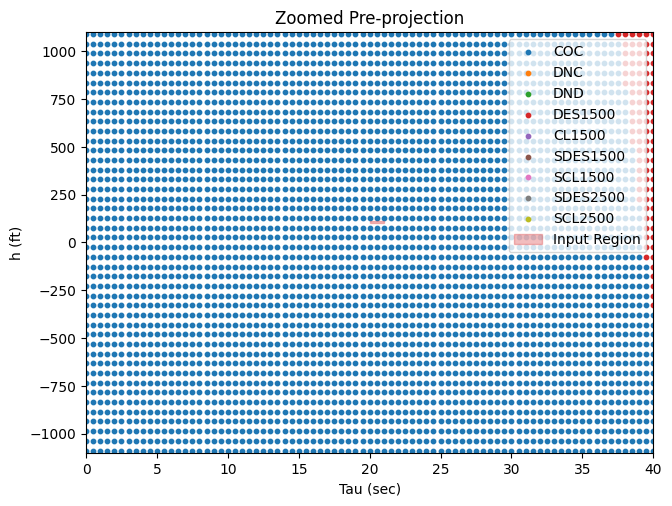

on epoch 42
304/304 [==============================] - 0s 2ms/stepnd accuracy


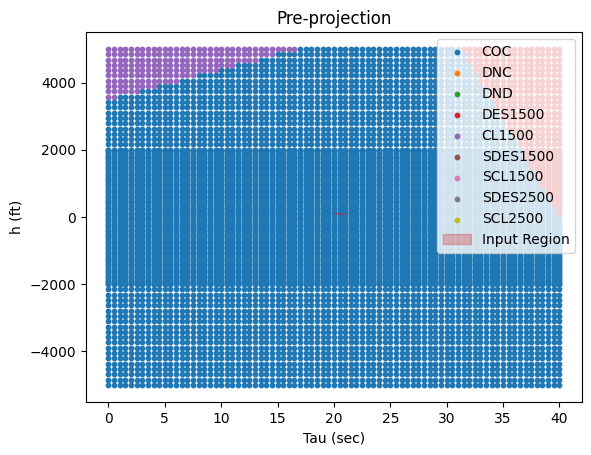

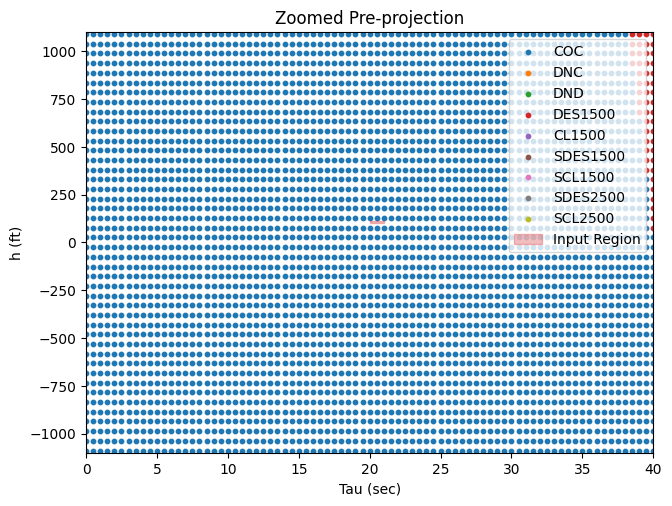

on epoch 43
304/304 [==============================] - 1s 2ms/stepand accur


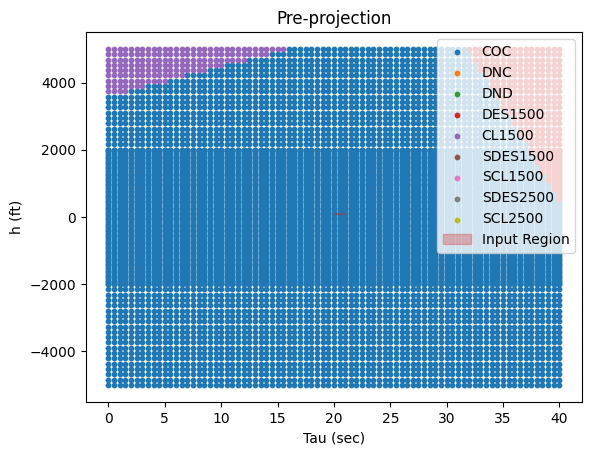

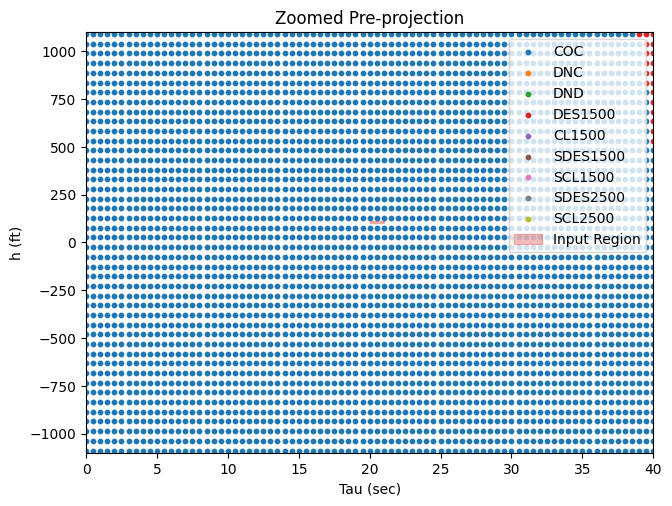

on epoch 44
304/304 [==============================] - 0s 2ms/stepand accurac


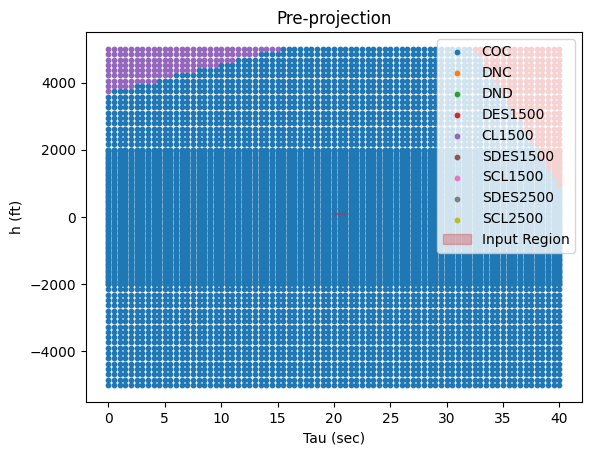

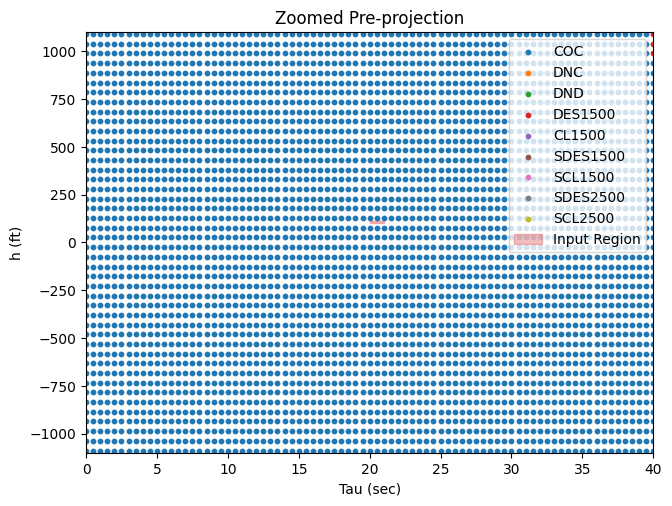

on epoch 45
304/304 [==============================] - 0s 2ms/stepand accurac


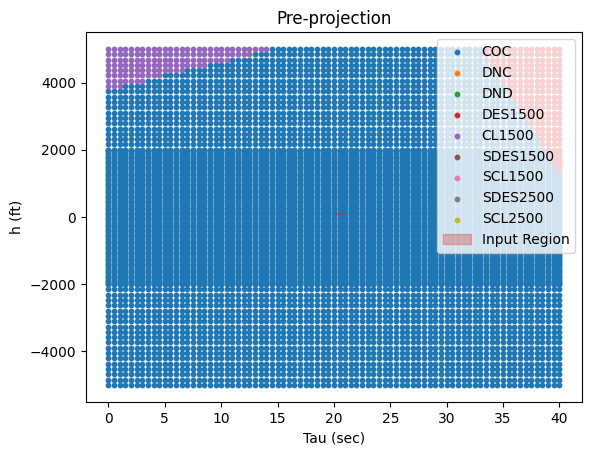

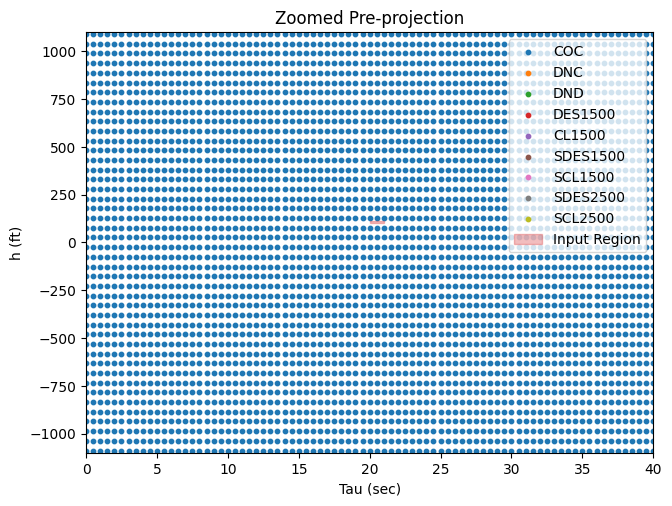

on epoch 46
304/304 [==============================] - 0s 2ms/stepand accurac


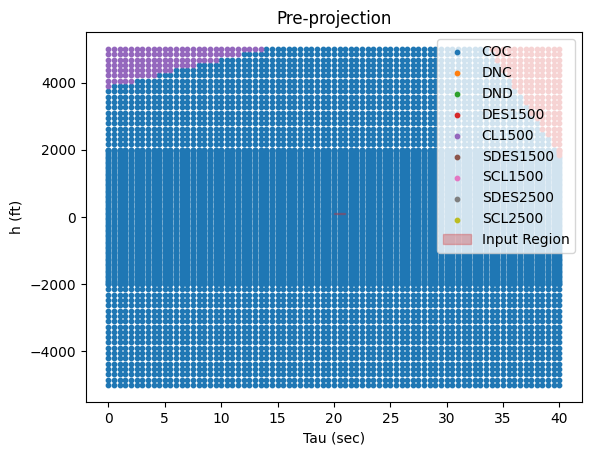

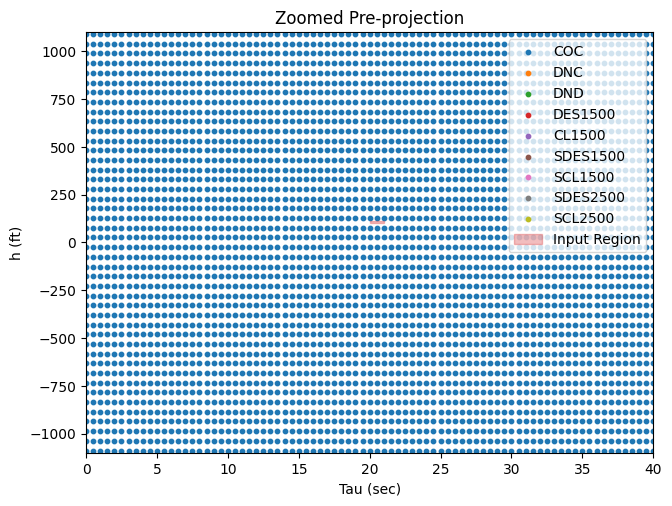

on epoch 47
304/304 [==============================] - 0s 2ms/stepand accurac


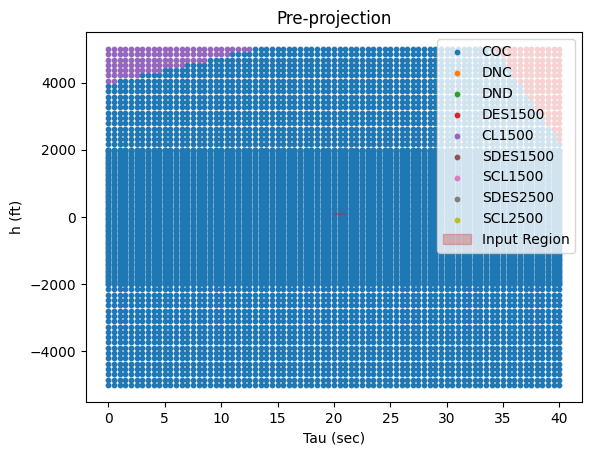

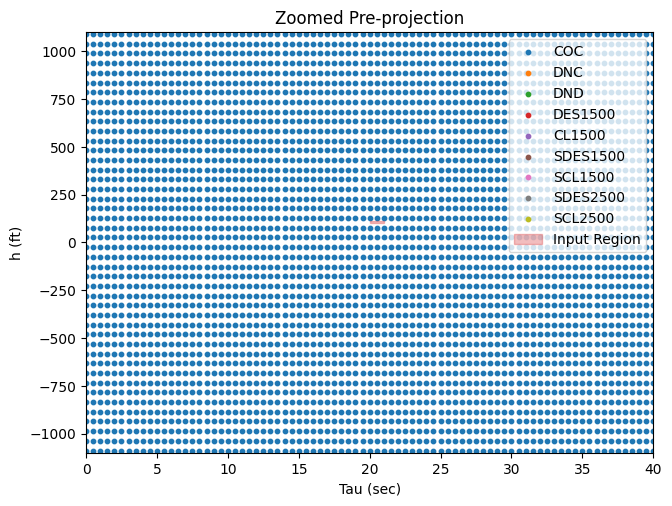

on epoch 48
304/304 [==============================] - 0s 2ms/stepand accurac


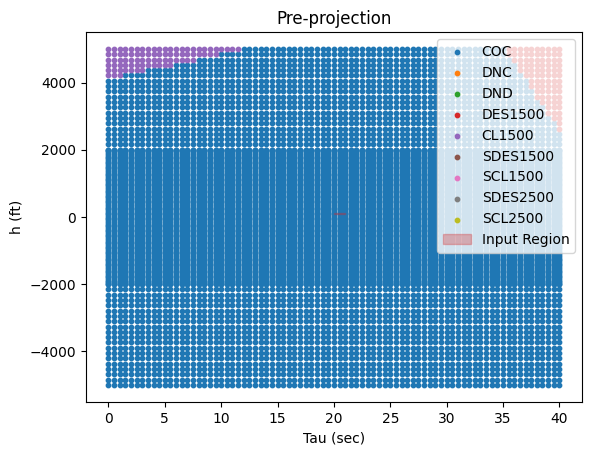

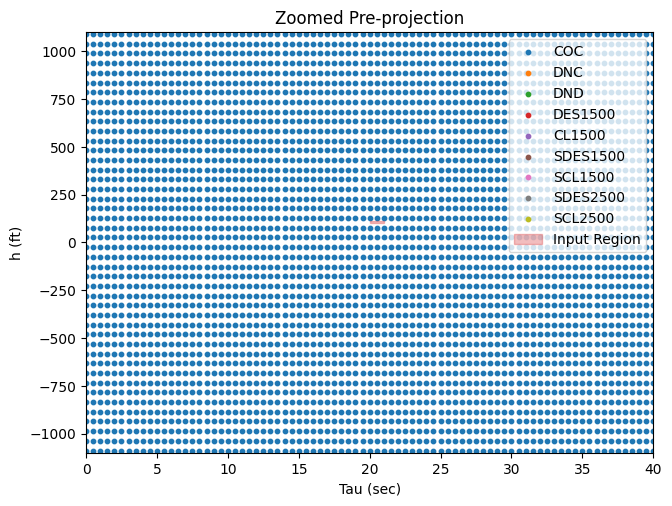

on epoch 49
304/304 [==============================] - 1s 2ms/stepand accurac


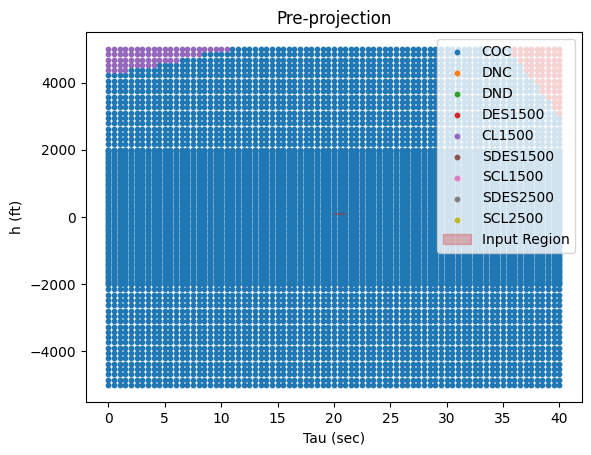

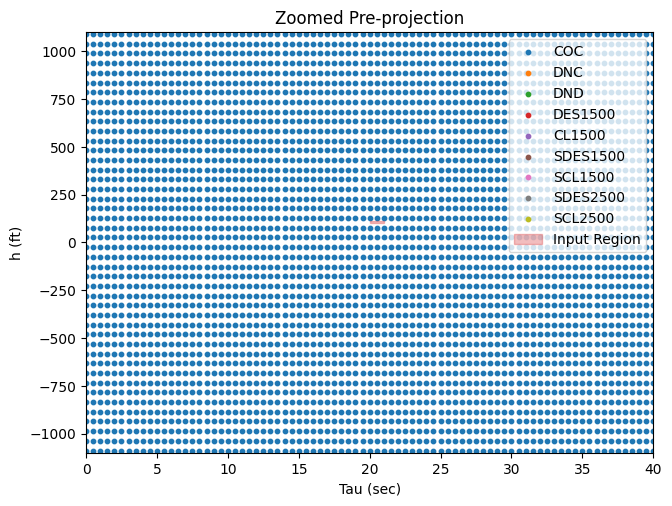

on epoch 50
304/304 [==============================] - 0s 2ms/stepand accurac


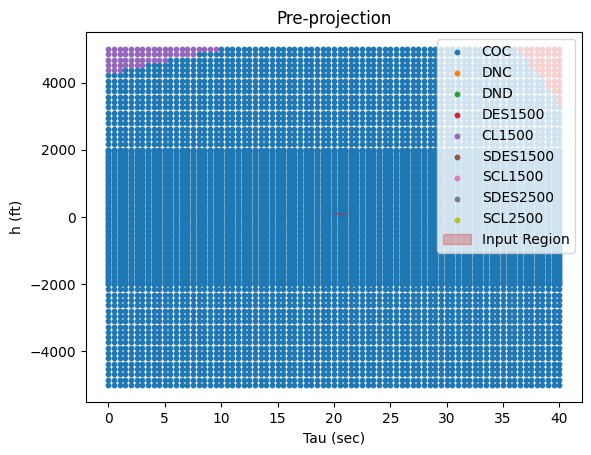

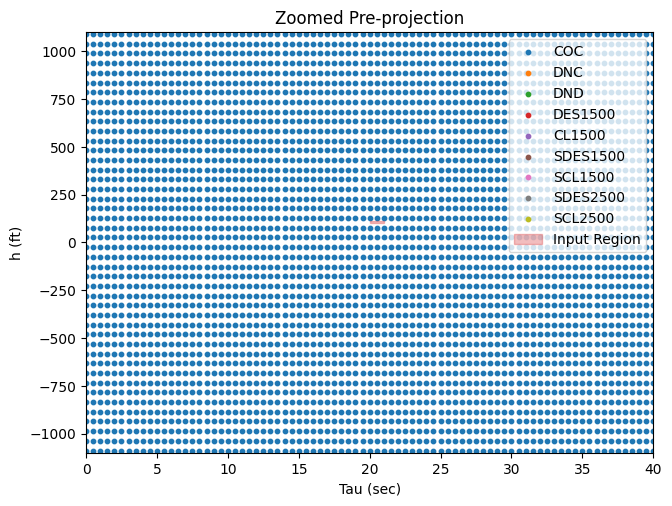

on epoch 51
304/304 [==============================] - 0s 2ms/stepand accurac


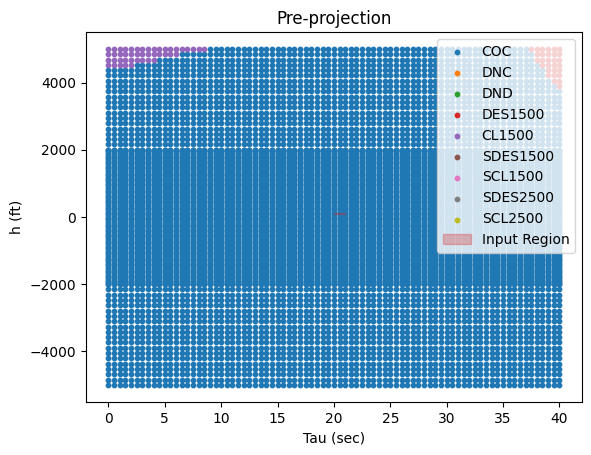

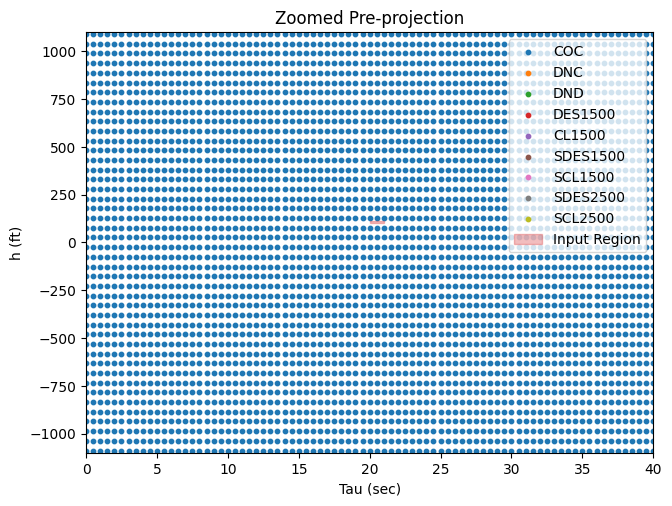

on epoch 52
304/304 [==============================] - 0s 2ms/stepand accurac


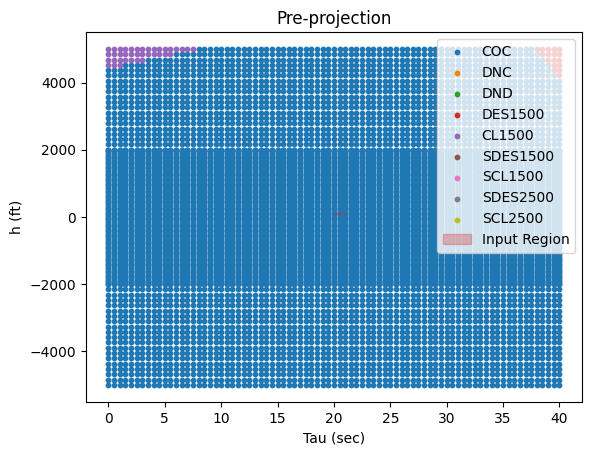

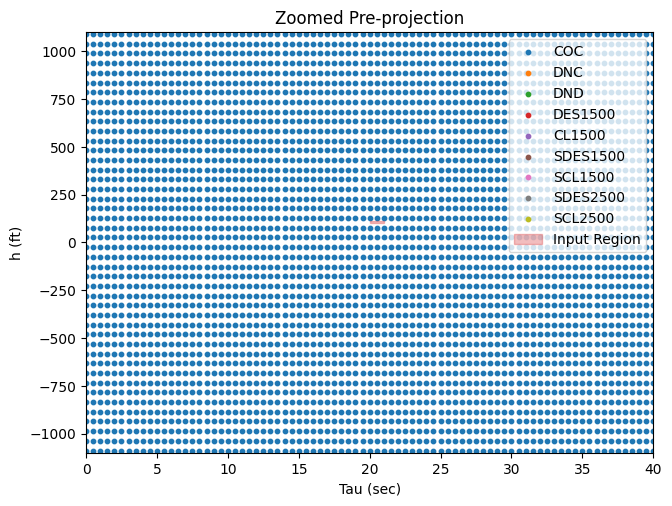

on epoch 53
304/304 [==============================] - 1s 2ms/stepand accur


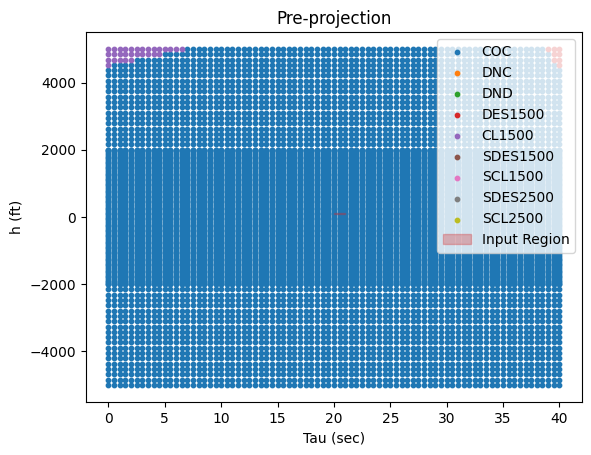

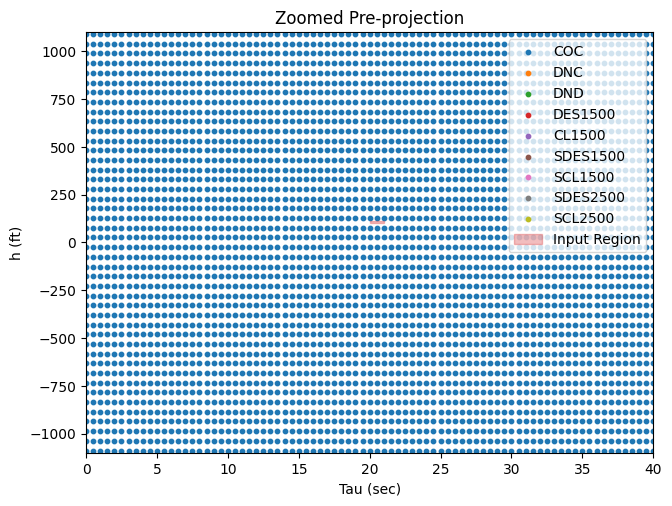

on epoch 54
304/304 [==============================] - 0s 2ms/stepand accurac


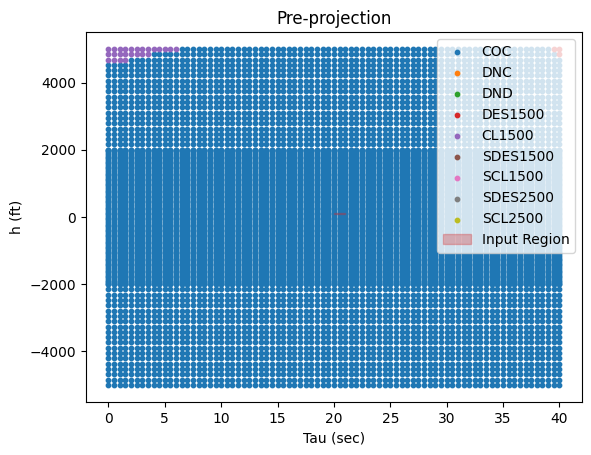

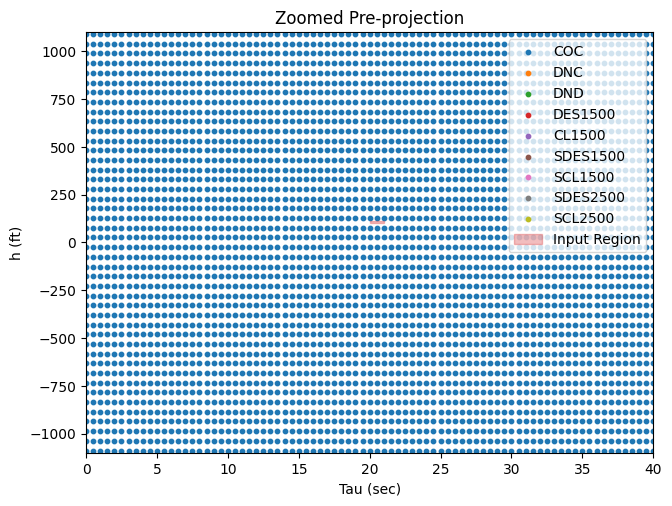

on epoch 55
304/304 [==============================] - 0s 2ms/stepand accurac


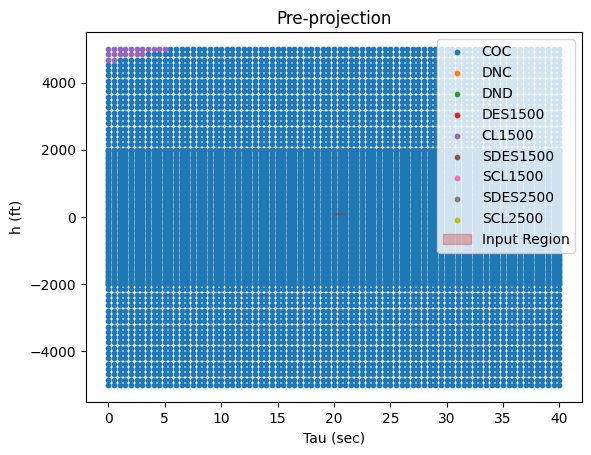

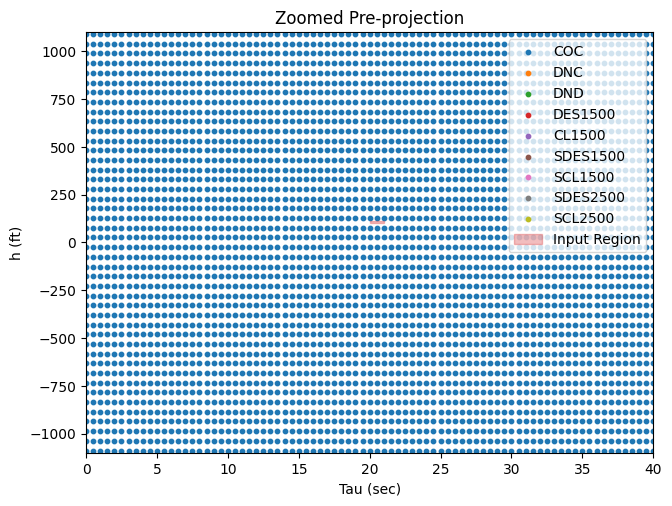

on epoch 56
304/304 [==============================] - 0s 2ms/stepand accurac


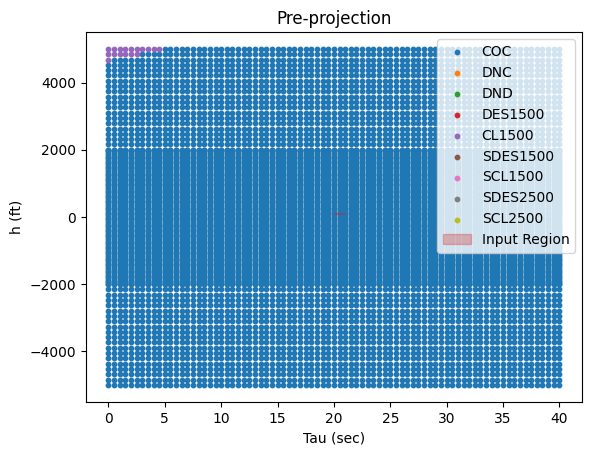

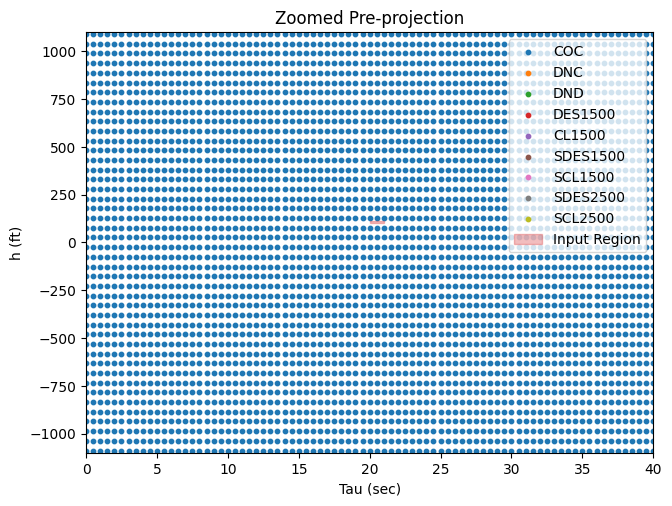

on epoch 57
304/304 [==============================] - 0s 2ms/stepand accurac


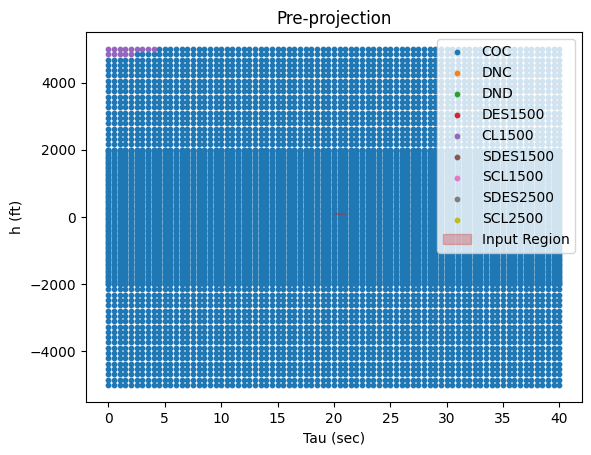

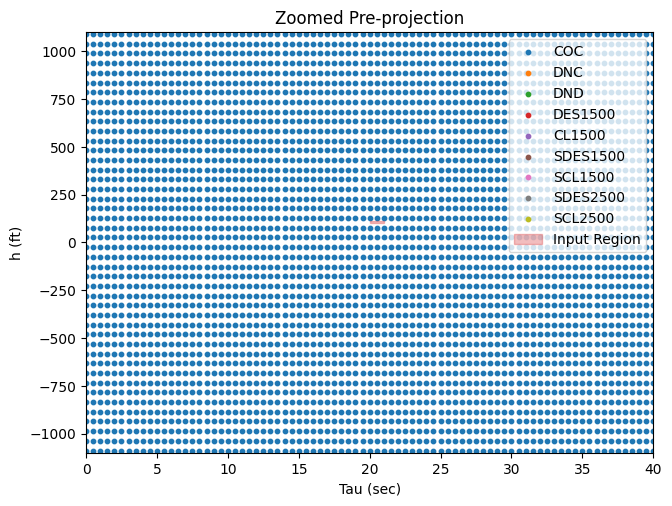

on epoch 58
304/304 [==============================] - 0s 2ms/stepand accuracy


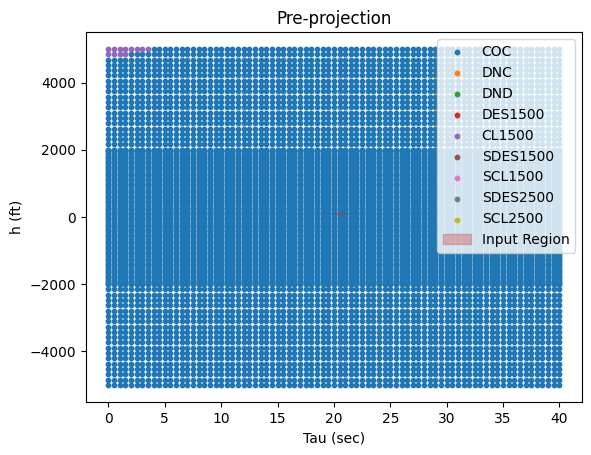

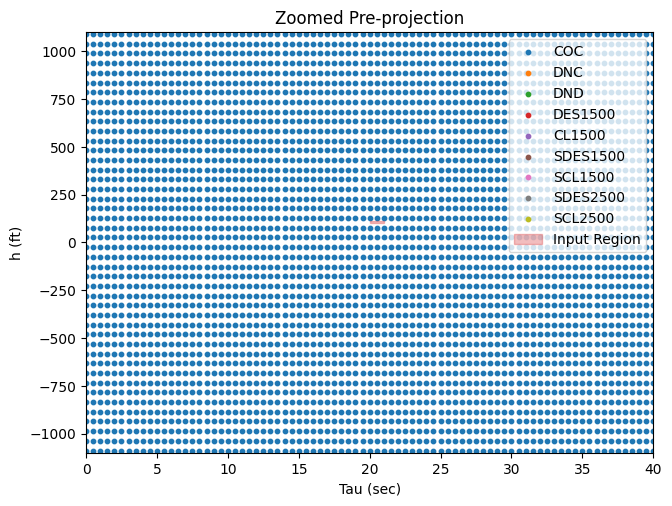

on epoch 59
304/304 [==============================] - 0s 2ms/stepand accuracy


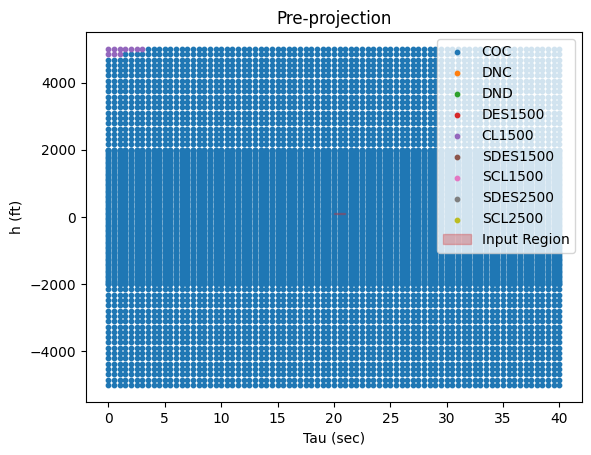

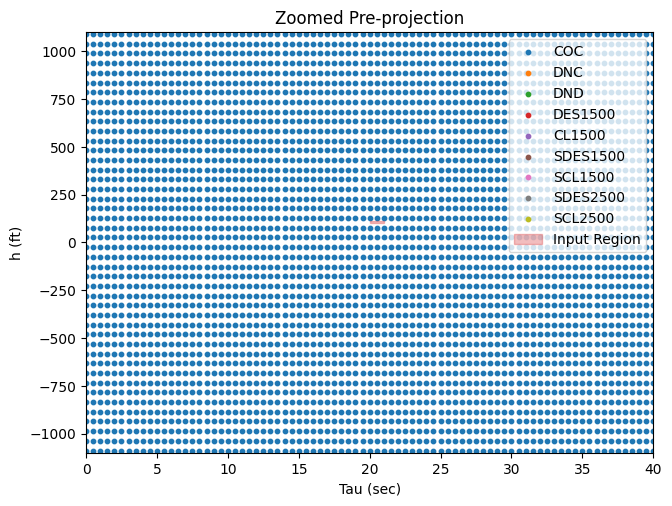

In [25]:
epoch_losses = []
epoch_accuracies = []
weights_before_projection = []
weights_after_projection = []
for epoch in range(totalEpochs):
    # if epoch % 5 == 0:
    print(f"on epoch {epoch}")

    rng = np.random.default_rng()

    train_indices = np.arange(X_train.shape[0])

    rng.shuffle(train_indices)  # in-place

    x_shuffled = X_train[train_indices, :]
    y_shuffled = Q[train_indices, :]

    x_batched = np.split(
        x_shuffled, np.arange(BATCH_SIZE, len(x_shuffled), BATCH_SIZE)
    )
    y_batched = np.split(
        y_shuffled, np.arange(BATCH_SIZE, len(y_shuffled), BATCH_SIZE)
    )

    dataset_batched = list(zip(x_batched, y_batched))
    batch_losses = []
    batch_accuracy_list = []
    epoch_accuracy = keras.metrics.CategoricalAccuracy()
    for step, (x_batch_train, y_batch_train) in enumerate(dataset_batched):
        with tf.GradientTape() as tape:
            y_pred = model(x_batch_train, training=True)  # Forward pass
            loss = asymMSE(y_batch_train, y_pred)
            epoch_accuracy.update_state(y_batch_train, y_pred)

            # accumulate data
            batch_losses.append(loss.numpy())
            batch_accuracy_list.append(epoch_accuracy.result())

        print(
            f"{np.round((step * 100.0) / num_batches, 1)}% through this epoch with loss",
            f"{np.round(loss.numpy(), 5)} and accuracy {np.round(epoch_accuracy.result(), 5)}\r",
            end="",)
        
        # Compute gradients
        trainable_vars = model.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        opt.apply_gradients(zip(gradients, trainable_vars))

    epoch_accuracies.append(batch_accuracy_list)
    epoch_losses.append(batch_losses)

    weights_before_projection.append([w.numpy() for w in model.layers[-1].weights])
    plot_policy(model, savefig=False, filename=f"images/fomlas-epoch{epoch}-pre-projection.pdf", 
                zoom=True, intervals=DES_INTERVAL, intervalcolor="C3", title="Pre-projection")   
    model.save("models/aug-08-standard-model-epoch-01.keras")
    # Parameters:
    # - h (ft): Altitude of intruder relative to ownship, [-8000, 8000]
    # - vO (ft/s): ownship vertical climb rate, [-100, 100]
    # - vI (ft/s): intruder vertical climb rate, [-100, 100]
    # - τ (sec): time to loss of horizontal separation
    output_interval, penultimate_interval = propagate_interval(
        normalize_interval(
            DES_INTERVAL
        ),  # MAKE SURE to normalize interval for reasonable results
        model,
        graph=False,
    )
#     print(normalize_interval(DES_INTERVAL))
#     print(propagate_interval(normalize_interval(DES_INTERVAL), model, graph=False))

#     if not check_max_score(output_interval, advisories["DES1500"]):
#         print(f"safe region test FAILED, interval was {output_interval}")
#         if epoch % EPOCH_TO_PROJECT == 0:
#             print(f"\nProjecting weights at epoch {epoch}.")
#             intervals_to_project = []
#             # go through all intervals, find max upper bound
#             max_upper_bound = None
#             for i, advisory_interval in enumerate(output_interval):
#                 if i == advisories["DES1500"]:
#                     continue
#                 else:
#                     if max_upper_bound is None:
#                         max_upper_bound = advisory_interval[0].sup
#                     else:
#                         max_upper_bound = max(
#                             advisory_interval[0].sup, max_upper_bound
#                         )

#             intervals_to_project = [advisories["DES1500"]]

#             weights_tf = model.layers[-1].weights
#             weights_np = weights_tf[0].numpy()
#             biases_np = weights_tf[1].numpy()

#             for idx in intervals_to_project:
#                 # weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
#                 weights_to_project = weights_np[:, idx]
#                 proj = project_weights(
#                     interval[max_upper_bound, max_upper_bound + INTERVAL_WIDTH],
#                     penultimate_interval,
#                     weights_to_project,
#                 )
#                 weights_np[:, idx] = proj
#                 # weights_np[:, idx] = proj[:-1]
#                 # biases_np[idx] = proj[-1]

#             model.layers[-1].set_weights([weights_np, biases_np])
#             output_interval, _ = propagate_interval(
#                 normalize_interval(DES_INTERVAL),
#                 model,
#                 graph=False,
#             )
#             print(f"After projecting, output interval is {output_interval}")
#             weights_after_projection.append(
#                 [w.numpy() for w in model.layers[-1].weights]
#             )
#             model.save("models/aug-08-post-projection-model-epoch-01.keras")


#     if not check_intervals(output_interval, desired_interval):
#         print(f"safe region test FAILED, interval was {output_interval}")
#         if epoch % EPOCH_TO_PROJECT == 0:
#             print(f"\nProjecting weights at epoch {epoch}.")
#             intervals_to_project = []
#             assert type(output_interval) == type(desired_interval)
#             if type(output_interval) is list:
#                 assert len(output_interval) == len(desired_interval)
#                 for i in range(len(output_interval)):
#                     if (
#                         desired_interval[i] is not None
#                         and output_interval[i] not in desired_interval[i]
#                     ):
#                         intervals_to_project.append(i)
#             else:
#                 intervals_to_project.append(0)

#             weights_tf = model.layers[-1].weights
#             weights_np = weights_tf[0].numpy()
#             biases_np = weights_tf[1].numpy()

#             for idx in intervals_to_project:
#                 weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
#                 proj = project_weights(
#                     desired_interval[idx], penultimate_interval, weights_to_project
#                 )
#                 weights_np[:, idx] = proj[:-1]
#                 biases_np[idx] = proj[-1]

#             model.layers[-1].set_weights([weights_np, biases_np])
#             output_interval, _ = propagate_interval(
#                 COC_INTERVAL,
#                 model,
#                 graph=False,
#             )
#             print(f"After projecting, output interval is {output_interval}")
#             weights_after_projection.append(
#                 [w.numpy() for w in model.layers[-1].weights]
#             )

#     else:
#         print(f"safe region test passed, interval was {output_interval}")

    # Logging outputs
    with open("projection_acas_aug08_coc.pickle", "wb") as f:
        data = {
            "accuracies": epoch_accuracies,
            "losses": epoch_losses,
            "weights_before_projection": weights_before_projection,
            "weights_after_projection": weights_after_projection,
        }
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
#     plot_policy(model, savefig=False, filename=f"images/fomlas-epoch{epoch}-post-projection.pdf", 
#                 zoom=True, intervals=DES_INTERVAL, intervalcolor="C3", title="Post-projection", vo=0, vi=0)

In [ ]:
penultimate_interval

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure()
plt.plot(batch_losses)
plt.show()

In [ ]:
advisories

In [ ]:
# COC high, SDES2500 low
desired_interval = [interval[7000, 15000],  # COC
                    None,           # DNC
                    None,           # DND
                    None,           # DES1500
                    None,           # CL1500
                    None,           # SDES1500
                    None,           # SCL1500
                    interval[-2000, 6000],  # SDES2500
                    None,           # SCL2500
                   ]

In [ ]:
def check_intervals(output_interval, goal_interval):
    assert type(output_interval) == type(goal_interval)
    if type(output_interval) is list:
        assert len(output_interval) == len(goal_interval)
        for i in range(len(output_interval)):
            if goal_interval[i] is not None and output_interval[i] not in goal_interval[i]:
                return False
        return True
    else:
        return output_interval in goal_interval

In [ ]:
output_interval

In [ ]:
desired_interval

In [ ]:
check_intervals(output_interval, desired_interval)

In [ ]:
# passes for all None, as expected
check_intervals(output_interval, [None] * len(output_interval)) 

## Multi-output Projection Approach

- copy the existing weights into a matrix to modify as projection occurs
- copy the existing biases into vector to modify as projection occures
- for each goal interval that is 1) specified and 2) violated
  - extract the weights corresponding to that interval (row index), like `weights[:, COC]`
  - add the bias term (single scalar after indexing `biases[COC]`)
  - project **only** those weights
  - write projected weights (all but last elements—shapes will work out) in the copied weight matrix
  - write projected bias (last element, is scalar) in the copied bias vector
- write the new projected weights/biases to the layer

In [ ]:
if not check_intervals(output_interval, desired_interval):
    print(f"safe region test FAILED, interval was {output_interval}")

In [ ]:
if epoch % EPOCH_TO_PROJECT == 0:
    print(f"\nProjecting weights at epoch {epoch}.")
    weights = model.layers[-1].weights
    
    intervals_to_project = []
    assert type(output_interval) == type(desired_interval)
    if type(output_interval) is list:
        assert len(output_interval) == len(desired_interval)
        for i in range(len(output_interval)):
            if desired_interval[i] is not None and output_interval[i] not in desired_interval[i]:
                intervals_to_project.append(i)
    else:
        intervals_to_project.append(0)

In [ ]:
intervals_to_project

In [ ]:
weights_tf = model.layers[-1].weights
weights_tf

In [ ]:
weights_np = weights[0].numpy()
biases_np = weights[1].numpy()

In [ ]:
# penultimate_interval

### Long approach

In [ ]:
for idx in intervals_to_project:
    weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
    print(weights_to_project)
    print(weights_to_project.shape)
    lowers = []
    uppers = []
    for i, ivl in enumerate(penultimate_interval):
        if weights_to_project[i] < 0:
            # swap order if negative
            lowers.append(ivl[0][1])
            uppers.append(ivl[0][0])
        else:
            lowers.append(ivl[0][0])
            uppers.append(ivl[0][1])

    interval_combinations = [lowers, uppers]
    constraint_vectors = [np.hstack([elem, 1]) for elem in interval_combinations]
    x = cp.Variable(weights_to_project.shape)
    constraints = []
    for constraint_vector in constraint_vectors:
        constraints.append(constraint_vector @ x >= desired_interval[0][0])
        constraints.append(constraint_vector @ x <= desired_interval[0][1])

    for i in range(len(weights_to_project)-1):
        constraint_row = np.zeros(weights_to_project.shape)
        np.put(constraint_row,i,1)
        if weights_to_project[i] >= 0:
            # enforce weight stays positive
            constraints.append(constraint_row @ x >= 0)
        else:
            # enforce weight stays negative
            constraints.append(constraint_row @ x <= 0)    

    obj = cp.Minimize(cp.norm(x - weights_to_project))
    prob = cp.Problem(obj, constraints)
    t1 = time.time()
    prob.solve()  # Returns the optimal value.
    print(f"solving took {time.time() - t1} seconds")
    print(f"optimization status: {prob.status}")
    proj = x.value
    # signs_proj = ["+" if weight >= 0 else "-" for weight in proj]
    # print(proj)
    # print(signs_proj)
    # print(coc_weights)
    # print(signs_orig)

    proj_out = 0
    for i, weight in enumerate(proj[:-1]):
        proj_out += penultimate_interval[i] * weight
    proj_out += proj[-1]
    print(f"interval after projection was {proj_out}")

    # sign_change_indices = []
    # for i in range(len(signs_proj)):
    #     if signs_proj[i] != signs_orig[i]:
    #         sign_change_indices.append(i)
    # print(f"{len(sign_change_indices)} indices changed sign during projection: {sign_change_indices}")

    # print(f"weights that flipped were originally {coc_weights[sign_change_indices]}")

### With function

In [ ]:
for idx in intervals_to_project:
    weights_to_project = np.hstack([weights_np[:, idx], biases_np[idx]])
    proj = project_weights(desired_interval[idx], 
                           penultimate_interval, 
                           weights_to_project)

    proj_out = 0
    for i, weight in enumerate(proj[:-1]):
        proj_out += penultimate_interval[i] * weight
    proj_out += proj[-1]
    print(f"interval after projection was {proj_out}")
    weights_np[:, idx] = proj[:-1]
    biases_np[idx] = proj[-1]

In [ ]:
proj[-1]

In [ ]:
biases_np

In [ ]:
biases_np - np.array([ 0.01702375, -0.01381799,  0.00414154,  0.05387181,  0.0431052 ,
        -0.11384217, -0.0549253 , -0.07289924, -0.07280885])

In [ ]:
# if epoch % EPOCH_TO_PROJECT == 0:
#     print(f"\nProjecting weights at epoch {epoch}.")
#     weights = model.layers[-1].weights
#     print(
#         f"Old weights: {np.squeeze(np.array([weight.numpy() for weight in weights]))}"
#     )
#     projected_weights = project_weights(
#         desired_interval,
#         penultimate_interval,
#         np.squeeze(np.array(weights)),
#     )
#     print(
#         f"Projected weights: {projected_weights} yield new interval: "
#         f"{penultimate_interval * projected_weights[0] + projected_weights[1]}"
#     )
#     proj_weight, proj_bias = projected_weights
#     model.layers[-1].set_weights(
#         [np.array([[proj_weight]]), np.array([proj_bias])]
#     )
#     # NOTE: assume positive weights
#     # TODO: handle both signs of weights

#     # print(optimizer.get_weights())
#     # optimizer.set_weights(last_safe_weights)
# else:
#     print(f"safe region test passed, interval was {output_interval}")

# Testing sign-aware projection

Without this, there's exponential behavior in ordering the interval upper/lower bounds when generating constraints, which leads to overflow and crashes.

In [ ]:
output_interval = [interval([-2260.4474587077575, 6254.7313829800505]),
 interval([-6016.414571449502, 6390.889435382497]),
 interval([-9953.235220686383, 6650.544893240611]),
 interval([-7094.378883646252, 4794.872261623323]),
 interval([-12704.856161526073, 6596.152293679708]),
 interval([-5798.244003059197, 2880.27408345843]),
 interval([-9798.605758997091, 1318.8253900765633]),
 interval([-6407.489985129032, 4301.543306242515]),
 interval([-9265.462345058428, 1938.5843370979335])]

In [ ]:
penultimate_interval = [interval([0.0]),
 interval([0.0, 819.5987759636605]),
 interval([1793.8983103436944, 5135.115473013564]),
 interval([0.0, 1266.6192015630404]),
 interval([0.0, 619.6017242371151]),
 interval([0.0, 415.47149718984383]),
 interval([0.0]),
 interval([3075.4781304744565, 5922.017075416204]),
 interval([0.0]),
 interval([2137.2280533522735, 6631.173178877855]),
 interval([0.0, 1917.1150893599386]),
 interval([4101.028183273791, 7081.891725089374]),
 interval([0.0]),
 interval([0.0, 1656.6367083129612]),
 interval([0.0, 1574.770634945266]),
 interval([0.0]),
 interval([583.9612652168341, 3669.2950529701707]),
 interval([6433.8031595782995, 9827.780209452081]),
 interval([0.0]),
 interval([0.0, 2498.04643175089]),
 interval([0.0]),
 interval([0.0, 303.3991584563141]),
 interval([0.0, 2435.9732251930036]),
 interval([0.0, 678.1315665107659]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0, 1853.624011731252]),
 interval([0.0]),
 interval([0.0, 1032.33090416972]),
 interval([0.0, 2013.1012942958077]),
 interval([0.0, 759.1690409388566]),
 interval([0.0]),
 interval([0.0, 2467.5971716121953]),
 interval([0.0]),
 interval([0.0]),
 interval([1984.2866849450206, 5191.768463778712]),
 interval([1041.2901222791538, 4408.43752449753]),
 interval([0.0, 1106.2138337778647]),
 interval([3452.5723961302288, 7176.104780478628]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0]),
 interval([0.0, 1975.5321958608674]),
 interval([0.0, 3249.1000602527665]),
 interval([826.0656894685214, 3859.086128004272])]


In [ ]:
total = 0
for ivl in penultimate_interval:
    if ivl[0].inf != ivl[0].sup:
        total += 1
total

In [ ]:
weights_tf = model.layers[-1].weights
weights_tf

In [ ]:
biases = np.array([ 0.02029374,  0.02516603, -0.00994892,  0.0222788 ,  0.03571415,
        -0.03154399, -0.04627901, -0.06161216, -0.03665822], dtype=np.float32)

In [ ]:
# weights = weights_tf[0].numpy()
# biases = weights_tf[1].numpy()

In [ ]:
weights

In [ ]:
weights = np.array([[-2.18333185e-01, -6.22537732e-01,  2.21074551e-01,
         2.81378120e-01, -3.42588812e-01, -1.35613531e-01,
         2.26456091e-01, -4.89725322e-02,  1.55175269e-01],
       [-7.80020282e-02,  1.84624806e-01, -2.06005573e-01,
        -2.80708075e-01, -1.92308322e-01, -2.32667681e-02,
        -1.32379875e-01, -1.13545403e-01,  4.20658849e-02],
       [ 3.25242668e-01,  2.08206803e-01, -2.44340464e-01,
         4.69880290e-02, -8.35797489e-02, -9.36886370e-02,
        -2.88362384e-01,  8.73668715e-02, -2.19115749e-01],
       [ 6.59989938e-02, -2.75809139e-01, -2.87649482e-01,
        -1.17637869e-02,  1.89444676e-01,  1.53859794e-01,
        -3.66265863e-01, -1.88385010e-01, -2.47587577e-01],
       [-2.26398073e-02, -7.94138312e-02,  3.55981328e-02,
         1.64122730e-02,  1.10089600e-01, -3.57257545e-01,
         1.00172698e-01, -2.59886473e-01, -7.50088990e-02],
       [ 1.22164980e-01,  1.84817791e-01,  3.35091770e-01,
         1.59232736e-01,  9.40671504e-01,  1.83394477e-01,
         6.33978188e-01,  2.69225627e-01,  4.43191305e-02],
       [ 1.23874284e-01, -7.60963321e-01,  2.16447443e-01,
         9.79461614e-03, -1.79705516e-01,  2.44781569e-01,
        -4.57653433e-01,  1.20109119e-01, -4.07250971e-01],
       [ 1.95406318e-01, -3.75177860e-02, -9.90792662e-02,
         1.56109244e-01, -2.43605152e-02, -4.01885323e-02,
        -2.19734907e-01,  1.31267577e-01,  1.70661449e-01],
       [-1.63188547e-01,  1.13966316e-01, -1.95072338e-01,
         2.22682804e-01,  2.02822894e-01, -1.28788367e-01,
         2.41370812e-01, -1.23383794e-02,  3.32103252e-01],
       [ 2.06917614e-01, -2.44279459e-01,  2.33837232e-01,
        -8.22154507e-02,  5.45158029e-01,  5.91765717e-02,
        -1.32632509e-01,  5.79342712e-03, -1.58340812e-01],
       [-1.94173846e-02, -8.92617553e-02,  3.14952023e-02,
         1.58400118e-01, -9.32605118e-02, -2.49547705e-01,
        -7.41416961e-02, -1.82480961e-01, -3.51565748e-01],
       [-1.81181714e-01,  1.24213204e-01,  3.26778442e-01,
         2.83223599e-01,  3.09085399e-01,  8.23983049e-04,
         9.04635042e-02, -1.17769040e-01, -2.02945471e-01],
       [-1.44330308e-01, -1.18324183e-01,  3.28021377e-01,
         2.71635950e-01, -6.09208345e-02,  2.97052830e-01,
        -3.01023751e-01,  2.73538560e-01, -3.04044578e-02],
       [ 2.59534210e-01, -1.09424151e-01, -3.38585585e-01,
         1.82545438e-01, -2.25749075e-01,  9.22391489e-02,
        -3.10919583e-01, -6.68276940e-03, -3.21906447e-01],
       [ 5.17473137e-03, -3.13345611e-01, -3.19618702e-01,
         9.60708261e-02, -1.36055395e-01, -1.99087515e-01,
        -2.31793806e-01, -2.40505308e-01,  1.27362564e-01],
       [ 3.31301123e-01,  2.14412868e-01,  2.41997942e-01,
        -2.97525108e-01,  2.83577353e-01, -1.20311894e-01,
        -2.16134906e-01, -7.20312670e-02, -1.80560634e-01],
       [ 1.00366406e-01,  8.68945345e-02,  5.08864224e-01,
        -8.82767588e-02,  2.21465349e-01,  1.27713546e-01,
         1.66512132e-01,  2.80042440e-01,  2.09720016e-01],
       [-8.25255141e-02,  2.08994180e-01, -1.06837042e-01,
        -3.48510087e-01,  1.65712997e-01,  5.54096960e-02,
        -2.23641351e-01, -1.34909645e-01,  1.42787054e-01],
       [ 5.75565696e-02, -1.30275607e-01,  1.53723851e-01,
         6.93859011e-02,  1.21206596e-01, -4.80810642e-01,
         1.81184098e-01, -1.33630246e-01, -4.38138805e-02],
       [ 2.08370045e-01, -1.14298493e-01, -3.69961977e-01,
         2.42887437e-01, -2.56165117e-01, -1.58821285e-01,
        -1.33631811e-01, -2.66872495e-01, -1.93805426e-01],
       [ 2.31464937e-01, -2.00037897e-01, -9.73619148e-02,
        -1.38476733e-02, -1.08140670e-01,  1.65265948e-01,
        -3.24441403e-01,  6.50982857e-02, -4.67101522e-02],
       [-1.90033093e-01,  1.23496808e-01,  1.61776051e-01,
         2.52557814e-01, -9.94549915e-02, -2.37577006e-01,
        -4.21294183e-01, -3.26920003e-01, -3.99972737e-01],
       [ 6.46226406e-02,  4.30513531e-01,  6.03858411e-01,
         2.00238988e-01, -5.85108757e-01,  2.63956100e-01,
        -2.39661992e-01,  3.70001256e-01,  1.52438518e-03],
       [-9.31944400e-02, -8.26838836e-02, -6.73755169e-01,
         2.83440262e-01,  2.62795925e-01,  3.88941281e-02,
         7.57192895e-02,  2.93633670e-01,  3.45981792e-02],
       [ 6.81845471e-02,  1.09168386e+00,  1.05029099e-01,
        -2.54411012e-01,  1.64576210e-02, -1.89687952e-01,
         3.78965408e-01, -8.45094249e-02,  5.14775932e-01],
       [-4.61942375e-01,  3.31163555e-01,  2.42191777e-01,
         6.87528670e-01,  8.14082503e-01,  5.10007143e-01,
         1.49687365e-01,  7.52033234e-01, -1.11784734e-01],
       [ 2.26745844e-01, -1.09356120e-01,  2.09188864e-01,
        -4.04216275e-02,  1.08391261e-02,  4.20173764e-01,
        -9.14842784e-02,  1.93628147e-01,  1.43444613e-01],
       [-1.15132309e-01, -4.05952066e-01, -2.71949738e-01,
        -8.71486962e-01, -1.87376700e-02, -6.23992383e-01,
        -2.22074598e-01, -4.42703187e-01, -2.80767620e-01],
       [ 1.46180779e-01, -2.49077275e-01,  3.21082503e-01,
        -2.36125201e-01, -2.65160471e-01, -8.94395337e-02,
         2.09774688e-01,  7.95840845e-02,  1.56208560e-01],
       [-1.69284314e-01,  1.83424041e-01, -2.43965670e-01,
        -1.93748966e-01, -1.10006414e-01, -1.56479195e-01,
        -5.34699522e-02,  1.55114755e-01,  7.76661485e-02],
       [ 1.22987730e-02,  4.65242833e-01,  7.47196138e-01,
         1.30903170e-01, -4.23293173e-01, -1.56462565e-01,
        -2.46845603e-01, -1.62104413e-01, -3.49277705e-01],
       [ 1.70015275e-01, -5.05107418e-02,  3.04429293e-01,
        -1.24148719e-01,  2.32333273e-01, -3.97730395e-02,
         1.49569184e-01, -2.15683296e-01, -2.29605168e-01],
       [ 6.79151639e-02,  4.13440436e-01,  1.61887348e-01,
         4.98310849e-02, -2.39159569e-01,  8.79221335e-02,
         1.40931889e-01,  1.85430586e-01,  1.25922292e-01],
       [-1.32595026e+00, -4.14898098e-01, -2.27178901e-01,
        -6.88801527e-01, -2.12719336e-01, -1.09122984e-01,
        -4.35671955e-01, -1.99768826e-01, -5.75941026e-01],
       [ 2.47517675e-01, -2.27498859e-01, -3.69096309e-01,
         3.40145111e-01,  1.33959860e-01,  2.69096255e-01,
        -2.35959262e-01,  3.04200709e-01,  1.87855437e-01],
       [ 9.53822136e-02, -4.02931094e-01, -3.78945678e-01,
         1.03416838e-01,  1.60253108e-01, -2.01285541e-01,
        -1.38552025e-01, -2.54651874e-01, -6.18772097e-02],
       [-2.67294586e-01,  1.70651451e-01, -2.25227758e-01,
         2.27904201e-01,  1.86727703e-01, -1.42123610e-01,
         2.36901984e-01,  4.01180573e-02, -1.36436522e-01],
       [-2.75177270e-01,  8.00679401e-02, -2.73740649e-01,
        -1.17558278e-01, -2.55102605e-01,  6.63628057e-02,
        -2.14794636e-01, -1.42564565e-01, -2.25268364e-01],
       [ 1.31988842e-02, -2.76278943e-01, -4.28179093e-02,
        -1.94231257e-01, -1.03825450e+00, -5.81424162e-02,
         4.70544677e-03,  1.94466725e-01, -4.12654847e-01],
       [-6.15995750e-02,  2.74473399e-01,  3.35875452e-01,
        -1.70225635e-01,  2.97078907e-01,  2.29435071e-01,
        -6.08222634e-02,  1.99780628e-01,  9.35441554e-02],
       [ 2.63991468e-02,  3.80530924e-01,  2.08077267e-01,
         1.90854684e-01,  2.13240102e-01, -2.90596008e-01,
         9.32675898e-02, -6.29713535e-01,  6.19140118e-02],
       [-2.98447967e-01, -3.95439714e-01,  2.90056288e-01,
        -3.05374473e-01,  2.33175918e-01, -1.55882984e-01,
        -2.72583991e-01, -8.54920894e-02, -2.77933031e-02],
       [ 1.88610494e-01, -2.88837016e-01,  1.01828352e-01,
        -7.75025308e-01, -2.17118904e-01,  1.60104305e-01,
        -3.91527802e-01,  9.97925363e-03, -3.67626190e-01],
       [ 8.74033049e-02,  8.59348699e-02, -4.55133140e-01,
         3.10212314e-01, -5.70085764e-01, -4.71005231e-01,
         1.44063056e-01, -4.30299133e-01,  1.43832803e-01],
       [-6.95287669e-03,  7.33533874e-02, -1.76221326e-01,
        -2.48765975e-01, -4.74544019e-01,  7.75902998e-03,
         1.99589327e-01, -1.80854067e-01,  9.49213728e-02]], dtype=np.float32)

In [ ]:
weights.shape

In [ ]:
biases.shape

In [ ]:
COC = 0

In [ ]:
weights[:, COC]

In [ ]:
biases[COC]

In [ ]:
coc_weights = np.hstack([weights[:, COC], biases[COC]])
coc_weights.shape

In [ ]:
coc_weights

In [ ]:
penultimate_interval

In [ ]:
len(penultimate_interval)

In [ ]:
goal_interval = interval[7000, 10000]

In [ ]:
# proj = project_weights(goal_interval, penultimate_interval, coc_weights, verbose=False)
# proj

In [ ]:
import itertools

In [ ]:
# elems = []
# for elem in penultimate_interval:
#     if elem[0][0] == elem[0][1]:
#         elems.append((elem[0][0],))
#     else:
#         elems.append(elem[0])
# interval_combinations = itertools.product(*elems)

In [ ]:
# constraint_vectors = [np.hstack([elem, 1]) for elem in interval_combinations]

In [ ]:
x = cp.Variable(coc_weights.shape)

## Sign-aware constraints

In [ ]:
import time

In [ ]:
lowers = []
uppers = []
signs_orig = []
# for i, ivl in enumerate(penultimate_interval):
#     if coc_weights[i] < 0:
#         # swap order if negative
#         lowers.append(ivl[0][1])
#         uppers.append(ivl[0][0])
#         signs_orig.append("-")
#     else:
#         lowers.append(ivl[0][0])
#         uppers.append(ivl[0][1])
#         signs_orig.append("+")
        
for i, ivl in enumerate(penultimate_interval):
    signs_orig.append("-" if coc_weights[i] < 0 else "+")
    if coc_weights[i] < 0:
        # swap order if negative
        lowers.append(ivl[0][1])
        uppers.append(ivl[0][0])
#     elif np.abs(coc_weights[i]) <= 0.1:
#         # do both, if very small
#         lowers.append(ivl[0][1])
#         uppers.append(ivl[0][0])
        
#         # # also add positive weights? causes bug 
#         # lowers.append(ivl[0][0])
#         # uppers.append(ivl[0][1])
    else:
        lowers.append(ivl[0][0])
        uppers.append(ivl[0][1])
        
# also account for bias
signs_orig.append("+" if coc_weights[i] > 0 else "-")

interval_combinations = [lowers, uppers]
constraint_vectors = [np.hstack([elem, 1]) for elem in interval_combinations]
x = cp.Variable(coc_weights.shape)
constraints = []
for constraint_vector in constraint_vectors:
    constraints.append(constraint_vector @ x >= goal_interval[0][0])
    constraints.append(constraint_vector @ x <= goal_interval[0][1])
    
for i in range(len(coc_weights)-1):
    constraint_row = np.zeros(coc_weights.shape)
    np.put(constraint_row,i,1)
    if coc_weights[i] >= 0:
        # enforce weight stays positive
        constraints.append(constraint_row @ x >= 0)
    else:
        # enforce weight stays negative
        constraints.append(constraint_row @ x <= 0)    

obj = cp.Minimize(cp.norm(x - coc_weights))
prob = cp.Problem(obj, constraints)
t1 = time.time()
prob.solve()  # Returns the optimal value.
print(f"solving took {time.time() - t1} seconds")
print(f"optimization status: {prob.status}")
proj = x.value
# signs_proj = ["+" if weight >= 0 else "-" for weight in proj]
# print(proj)
# print(signs_proj)
# print(coc_weights)
# print(signs_orig)

proj_out = 0
for i, weight in enumerate(proj[:-1]):
    proj_out += penultimate_interval[i] * weight
proj_out += proj[-1]
print(f"interval after projection was {proj_out}")

# sign_change_indices = []
# for i in range(len(signs_proj)):
#     if signs_proj[i] != signs_orig[i]:
#         sign_change_indices.append(i)
# print(f"{len(sign_change_indices)} indices changed sign during projection: {sign_change_indices}")

# print(f"weights that flipped were originally {coc_weights[sign_change_indices]}")

In [ ]:
constraint_vectors

## Naive constraints

In [ ]:
interval_combinations = [[ivl[0][0] for ivl in penultimate_interval], [ivl[0][1] for ivl in penultimate_interval]]
signs_proj = ["+" if weight > 0 else "-" for weight in coc_weights]
constraint_vectors = [np.hstack([elem, 1]) for elem in interval_combinations]
constraints = []
for constraint_vector in constraint_vectors:
    constraints.append(constraint_vector @ x >= goal_interval[0][0])
    constraints.append(constraint_vector @ x <= goal_interval[0][1])

    obj = cp.Minimize(cp.norm(x - coc_weights))
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
proj = x.value
signs_proj = ["+" if weight > 0 else "-" for weight in proj]
print(proj)

proj_out = 0
for i, weight in enumerate(proj[:-1]):
    proj_out += penultimate_interval[i] * weight
proj_out += proj[-1]
print(f"interval after projection was {proj_out}")
# NOTE: symmetric miss of target interval, interestingly

sign_change_indices = []
for i in range(len(signs_proj)):
    if signs_proj[i] != signs_orig[i]:
        sign_change_indices.append(i)
print(f"{len(sign_change_indices)} indices changed sign during projection: {sign_change_indices}")

print(f"weights that flipped were originally {coc_weights[sign_change_indices]}")

In [ ]:
obj = cp.Minimize(cp.norm(x - coc_weights))
prob = cp.Problem(obj, constraints)
prob.solve()  # Returns the optimal value.
proj = x.value
proj

In [ ]:
proj_out = 0
for i, weight in enumerate(proj[:-1]):
    proj_out += penultimate_interval[i] * weight
proj_out += proj[-1]
proj_out